In [3]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from os import path
from utils import *

import pandas as pd
HDFStore=pd.HDFStore

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [20, 10]
plt.style.use('fivethirtyeight')
import random


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np

from glob import glob
import os
from scipy.signal import resample


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [28]:
# training parameters
seed= 42

dr=0.2
lr2=1e-4
lr1=1e-4
lr=8e-4

num_epochs=5000
mini_batch_size=4

lstm_units=64
num_classes=3

today="20220908"

print_sample=False

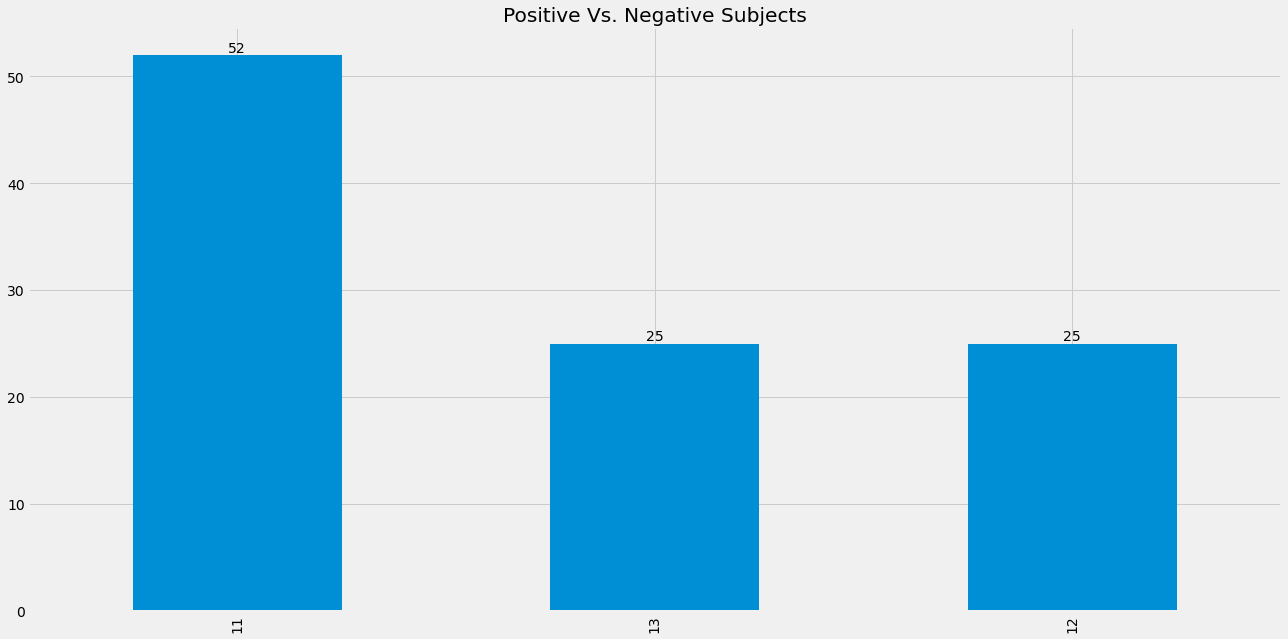

In [4]:
levels = pd.read_csv('/data/elekin/data/results/fmri/preproc/cbl/cbl_levels_{}.csv'.format(today),index_col=0)
levels.sample(5)
labels = (levels.Level3.dropna()).astype(np.int16)
ax = labels.value_counts().plot.bar(title='Positive Vs. Negative Subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

In [5]:
file = '/data/elekin/data/results/fmri/preproc/cbl/{}/cbl_extracted_ts_{}.csv'
data = []
for suj in labels.index.values:
    df = pd.read_csv(file.format(suj, today), header=None)
    data.append(df.values)
features = np.array(data)
features.shape

(102, 158, 28)

In [6]:
flatten_features = features.reshape(features.shape[0], features.shape[1]*features.shape[2])
flatten_features.shape

(102, 4424)

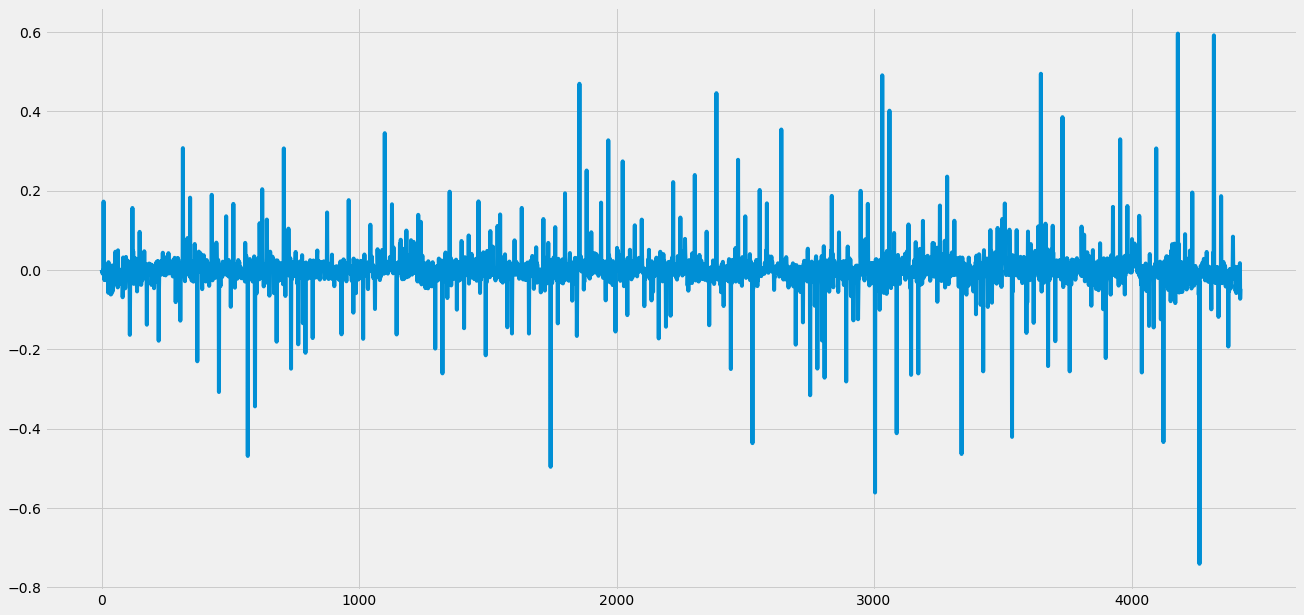

In [7]:
plt.style.use('fivethirtyeight')

idx = random.randint(0,105)
_=plt.plot(flatten_features[0])

In [8]:
from sklearn import preprocessing
#multi labels
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(labels).astype(np.int16)
#binary labels
#le = LabelEncoder().fit(labels.values.ravel())
#y = le.fit_transform(labels.values.ravel()).astype(np.int16)
#y

In [9]:
X = flatten_features.astype(np.float32)
X.shape

(102, 4424)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [11]:
x_train.shape, x_test.shape

((68, 4424), (34, 4424))

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

if print_sample:
    for feat, targ in test_dataset.take(10):
        print ('Features test: {}, Target: {}'.format(feat, targ))

    for feat, targ in test_dataset.take(10):
        print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))

17 train batches and 9 test batches of 4 mini batch size and 4 steps per epoch


## FCNN ARCHITECTURE ANALISYS

Some training helpers functions

In [29]:
def get_callbacks(name):
    return [
        #tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, min_delta=1e-4, mode='min'),
        #tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, train_dataset, test_dataset, name, optimizer=None, max_epochs=1000):
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(name),
                        verbose=1, shuffle=False)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [30]:
size_histories = {}

In [44]:
num_features = x_train.shape[1]
tiny = tf.keras.models.Sequential([
    tf.keras.layers.Dense(24, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)])

size_histories['fcnn/tiny'] = compile_and_fit(tiny, train_dataset, 
                                              test_dataset,
                                              "fcnn/tiny", 
                                               optimizer=get_optimizer(),
#                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                106200    
                                                                 
 dense_1 (Dense)             (None, 3)                 75        
                                                                 
Total params: 106,275
Trainable params: 106,275
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
17/17 [==============================] - 1s 6ms/step - loss: 1.1024 - accuracy: 0.3529 - val_loss: 1.0930 - val_accuracy: 0.3235
Epoch 2/5000
17/17 [==============================] - 0s 2ms/step - loss: 1.0723 - accuracy: 0.4853 - val_loss: 1.0915 - val_accuracy: 0.3235
Epoch 3/5000
17/17 [==============================] - 0s 2ms/step - loss: 1.0504 - accuracy: 0.6324 - val_loss: 1.0903 - val_accuracy: 0.3235
Epoch 4/5000
17/17 [

17/17 [==============================] - 0s 2ms/step - loss: 0.5282 - accuracy: 1.0000 - val_loss: 1.0718 - val_accuracy: 0.3235
Epoch 54/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.5218 - accuracy: 1.0000 - val_loss: 1.0716 - val_accuracy: 0.3235
Epoch 55/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.5155 - accuracy: 1.0000 - val_loss: 1.0714 - val_accuracy: 0.3235
Epoch 56/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.5094 - accuracy: 1.0000 - val_loss: 1.0713 - val_accuracy: 0.3235
Epoch 57/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.5033 - accuracy: 1.0000 - val_loss: 1.0710 - val_accuracy: 0.3235
Epoch 58/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.4974 - accuracy: 1.0000 - val_loss: 1.0709 - val_accuracy: 0.3235
Epoch 59/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.4916 - accuracy: 1.0000 - val_loss: 1.0707 - val_accuracy: 0.3235
Epoch 60/5000

17/17 [==============================] - 0s 2ms/step - loss: 0.2928 - accuracy: 1.0000 - val_loss: 1.0725 - val_accuracy: 0.3824
Epoch 111/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.2902 - accuracy: 1.0000 - val_loss: 1.0727 - val_accuracy: 0.3529
Epoch 112/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.2877 - accuracy: 1.0000 - val_loss: 1.0729 - val_accuracy: 0.3529
Epoch 113/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.2852 - accuracy: 1.0000 - val_loss: 1.0731 - val_accuracy: 0.3529
Epoch 114/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.2827 - accuracy: 1.0000 - val_loss: 1.0732 - val_accuracy: 0.3529
Epoch 115/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.2802 - accuracy: 1.0000 - val_loss: 1.0733 - val_accuracy: 0.3529
Epoch 116/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.2778 - accuracy: 1.0000 - val_loss: 1.0734 - val_accuracy: 0.3529
Epoch 1

Epoch 167/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.1875 - accuracy: 1.0000 - val_loss: 1.0839 - val_accuracy: 0.3529
Epoch 168/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.1863 - accuracy: 1.0000 - val_loss: 1.0841 - val_accuracy: 0.3529
Epoch 169/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.1850 - accuracy: 1.0000 - val_loss: 1.0843 - val_accuracy: 0.3529
Epoch 170/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.1837 - accuracy: 1.0000 - val_loss: 1.0846 - val_accuracy: 0.3529
Epoch 171/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.1825 - accuracy: 1.0000 - val_loss: 1.0848 - val_accuracy: 0.3529
Epoch 172/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.1812 - accuracy: 1.0000 - val_loss: 1.0850 - val_accuracy: 0.3529
Epoch 173/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.1800 - accuracy: 1.0000 - val_loss: 1.0853 - val_accuracy:

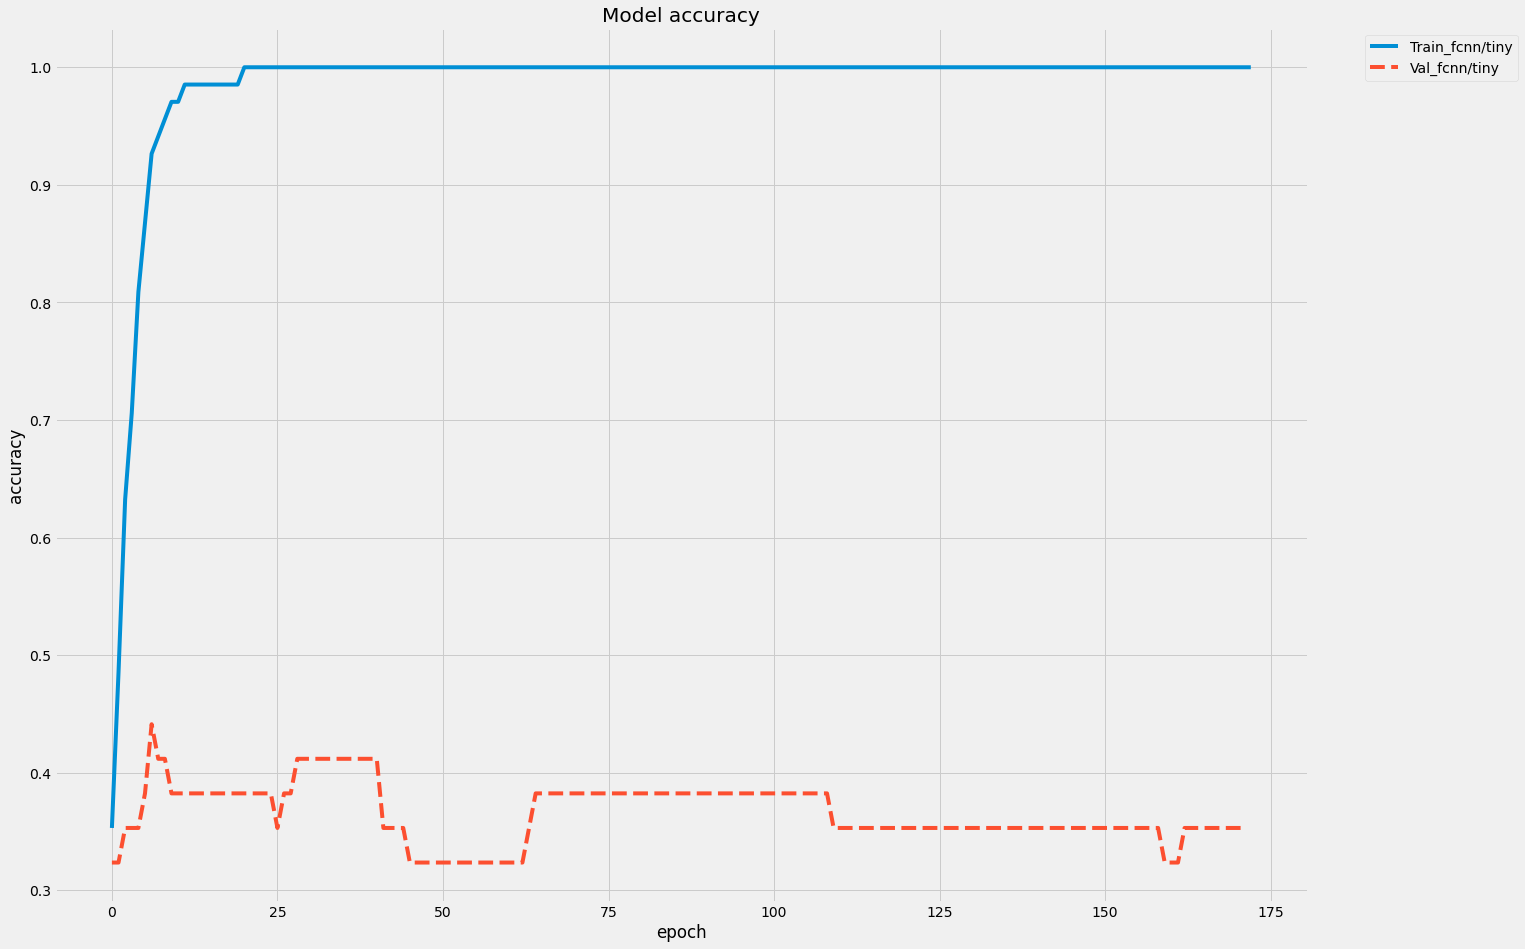

In [45]:
plt.rcParams['figure.figsize'] = [20.0, 15.0]
plot_report(size_histories, metric='accuracy')

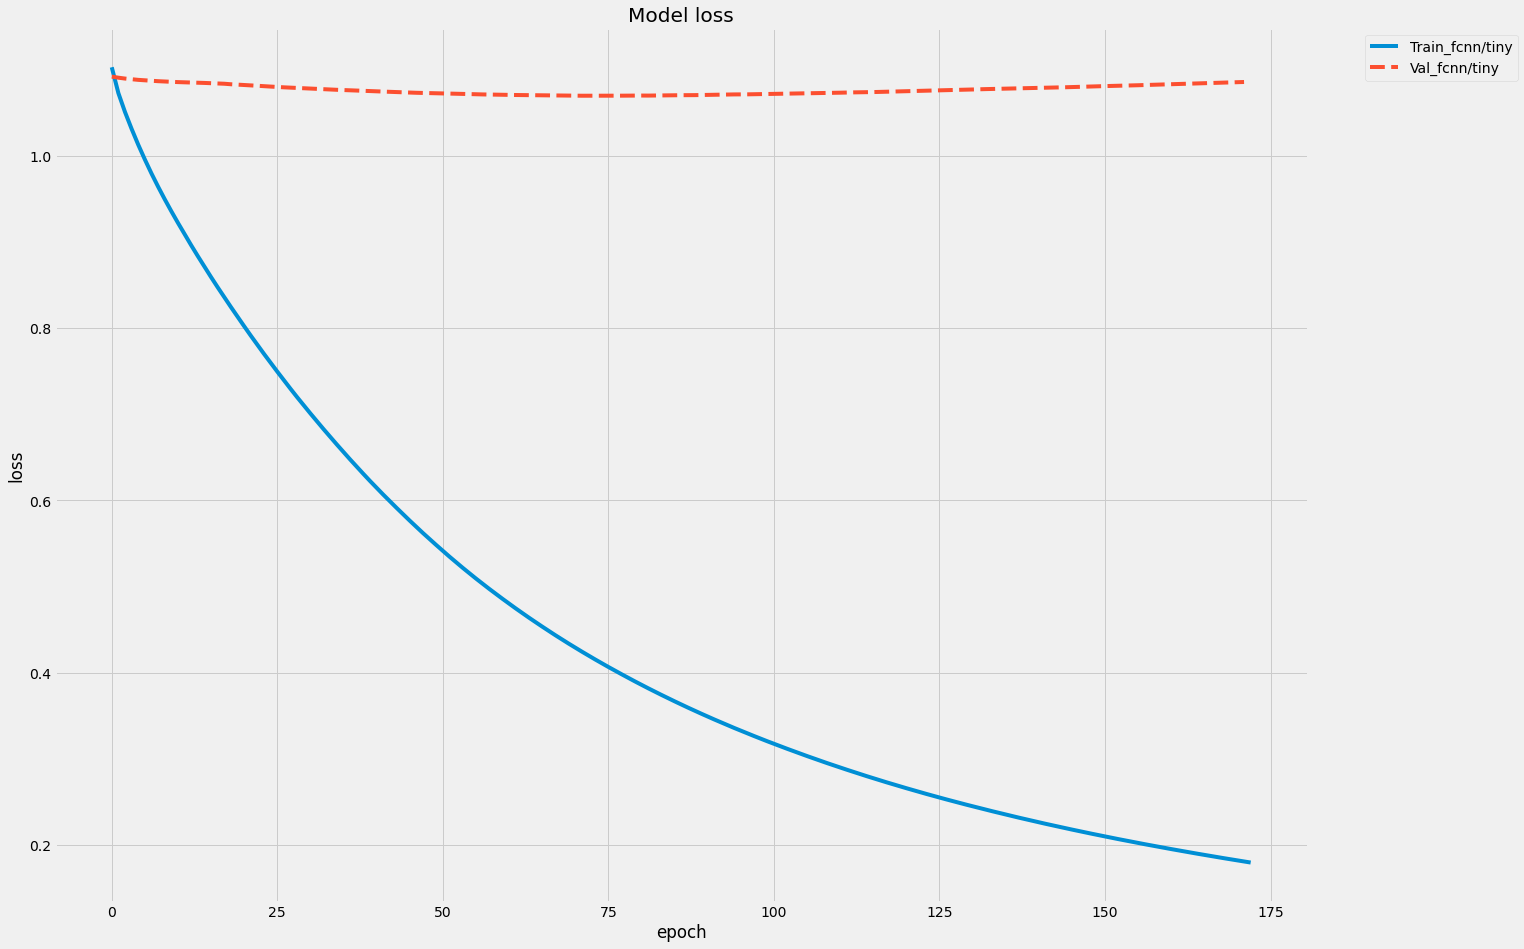

In [46]:
plot_report(size_histories, 'loss')

In [50]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(24, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)
])
size_histories['fcnn/small'] = compile_and_fit(small_model, train_dataset, 
                                              test_dataset,'fcnn/small',
                                               optimizer=get_optimizer(),
#                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/small'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/small'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                106200    
                                                                 
 dense_1 (Dense)             (None, 8)                 200       
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 106,427
Trainable params: 106,427
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
17/17 [==============================] - 0s 6ms/step - loss: 1.0998 - accuracy: 0.2794 - val_loss: 1.1492 - val_accuracy: 0.2059
Epoch 2/5000
17/17 [==============================] - 0s 2ms/step - loss: 1.0740 - accuracy: 0.5294 - val_loss: 1.1507 - val_accuracy: 0.2059
Epoch 3/5000
17/17 [==========

17/17 [==============================] - 0s 2ms/step - loss: 0.5278 - accuracy: 0.9853 - val_loss: 1.2275 - val_accuracy: 0.3824
Epoch 53/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.5202 - accuracy: 0.9853 - val_loss: 1.2288 - val_accuracy: 0.3824
Epoch 54/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.5127 - accuracy: 0.9853 - val_loss: 1.2295 - val_accuracy: 0.3824
Epoch 55/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.5052 - accuracy: 0.9853 - val_loss: 1.2304 - val_accuracy: 0.3824
Epoch 56/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.4978 - accuracy: 1.0000 - val_loss: 1.2315 - val_accuracy: 0.3824
Epoch 57/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.4906 - accuracy: 1.0000 - val_loss: 1.2324 - val_accuracy: 0.3824
Epoch 58/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.4835 - accuracy: 1.0000 - val_loss: 1.2334 - val_accuracy: 0.3824
Epoch 59/5000

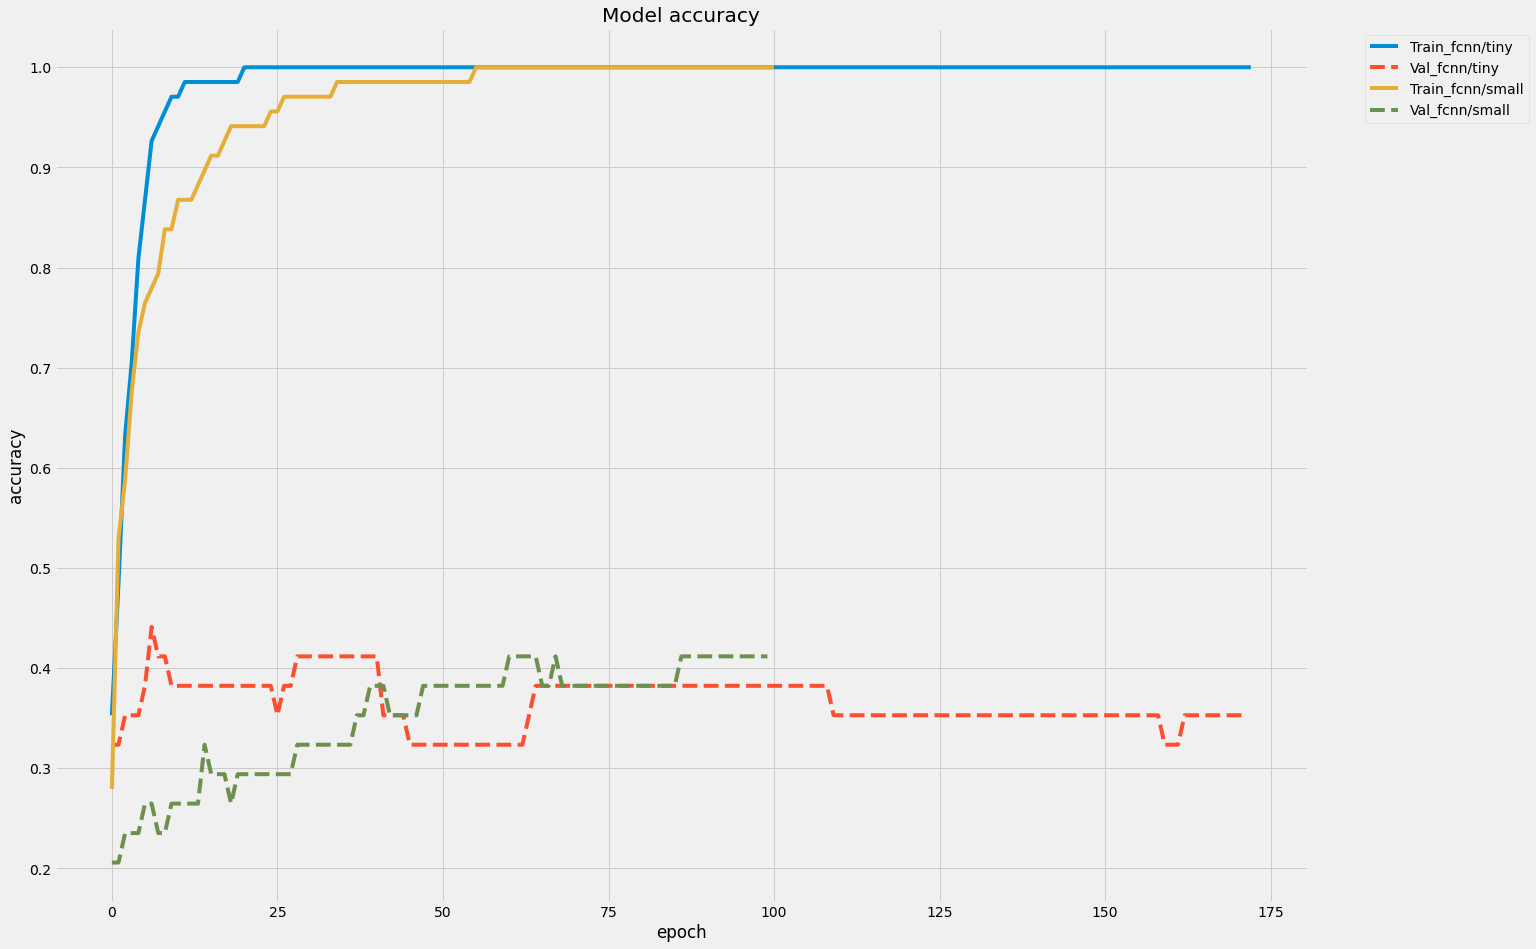

In [51]:
plot_report(size_histories)

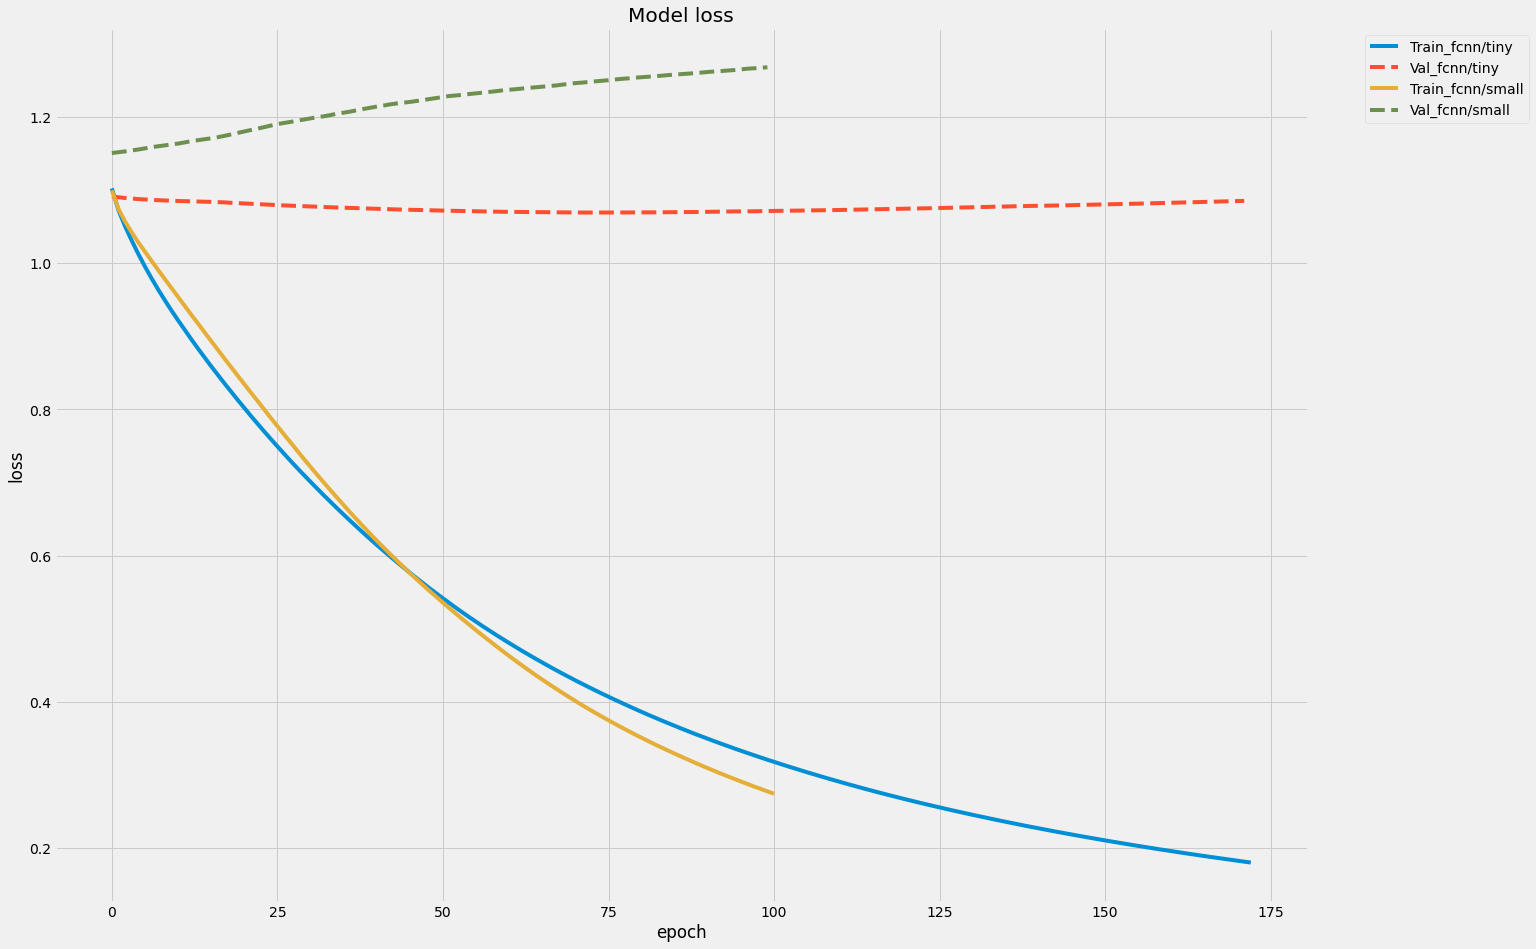

In [52]:
plot_report(size_histories, 'loss')

In [58]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(24, activation=tf.nn.relu, input_shape=(num_features,)),  
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)
])
size_histories['fcnn/large'] = compile_and_fit(large_model, train_dataset, 
                                              test_dataset, "fcnn/large",
                                              optimizer=get_optimizer(), 
                                              max_epochs=num_epochs)

print("Evaluation")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/large'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                106200    
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 16)                400       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 107,523
Trainable params: 107,523
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
17/17 [==============================

Epoch 51/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.5699 - accuracy: 0.7059 - val_loss: 1.0937 - val_accuracy: 0.5588
Epoch 52/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.5622 - accuracy: 0.7059 - val_loss: 1.0963 - val_accuracy: 0.5588
Epoch 53/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.5551 - accuracy: 0.7206 - val_loss: 1.0989 - val_accuracy: 0.5588
Epoch 54/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.5478 - accuracy: 0.7206 - val_loss: 1.1020 - val_accuracy: 0.5588
Epoch 55/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.5407 - accuracy: 0.7206 - val_loss: 1.1046 - val_accuracy: 0.5588
Epoch 56/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.5339 - accuracy: 0.7206 - val_loss: 1.1080 - val_accuracy: 0.5588
Epoch 57/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.5269 - accuracy: 0.7353 - val_loss: 1.1113 - val_accuracy: 0.5588

17/17 [==============================] - 0s 2ms/step - loss: 0.2774 - accuracy: 1.0000 - val_loss: 1.3519 - val_accuracy: 0.5294
Epoch 109/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.2752 - accuracy: 1.0000 - val_loss: 1.3559 - val_accuracy: 0.5294
Epoch 110/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.2732 - accuracy: 1.0000 - val_loss: 1.3603 - val_accuracy: 0.5294
Epoch 111/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.2710 - accuracy: 1.0000 - val_loss: 1.3652 - val_accuracy: 0.5294
Epoch 112/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.2689 - accuracy: 1.0000 - val_loss: 1.3688 - val_accuracy: 0.5294
Epoch 113/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.2670 - accuracy: 1.0000 - val_loss: 1.3736 - val_accuracy: 0.5294
Epoch 114/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.2653 - accuracy: 1.0000 - val_loss: 1.3781 - val_accuracy: 0.5294
Epoch 1

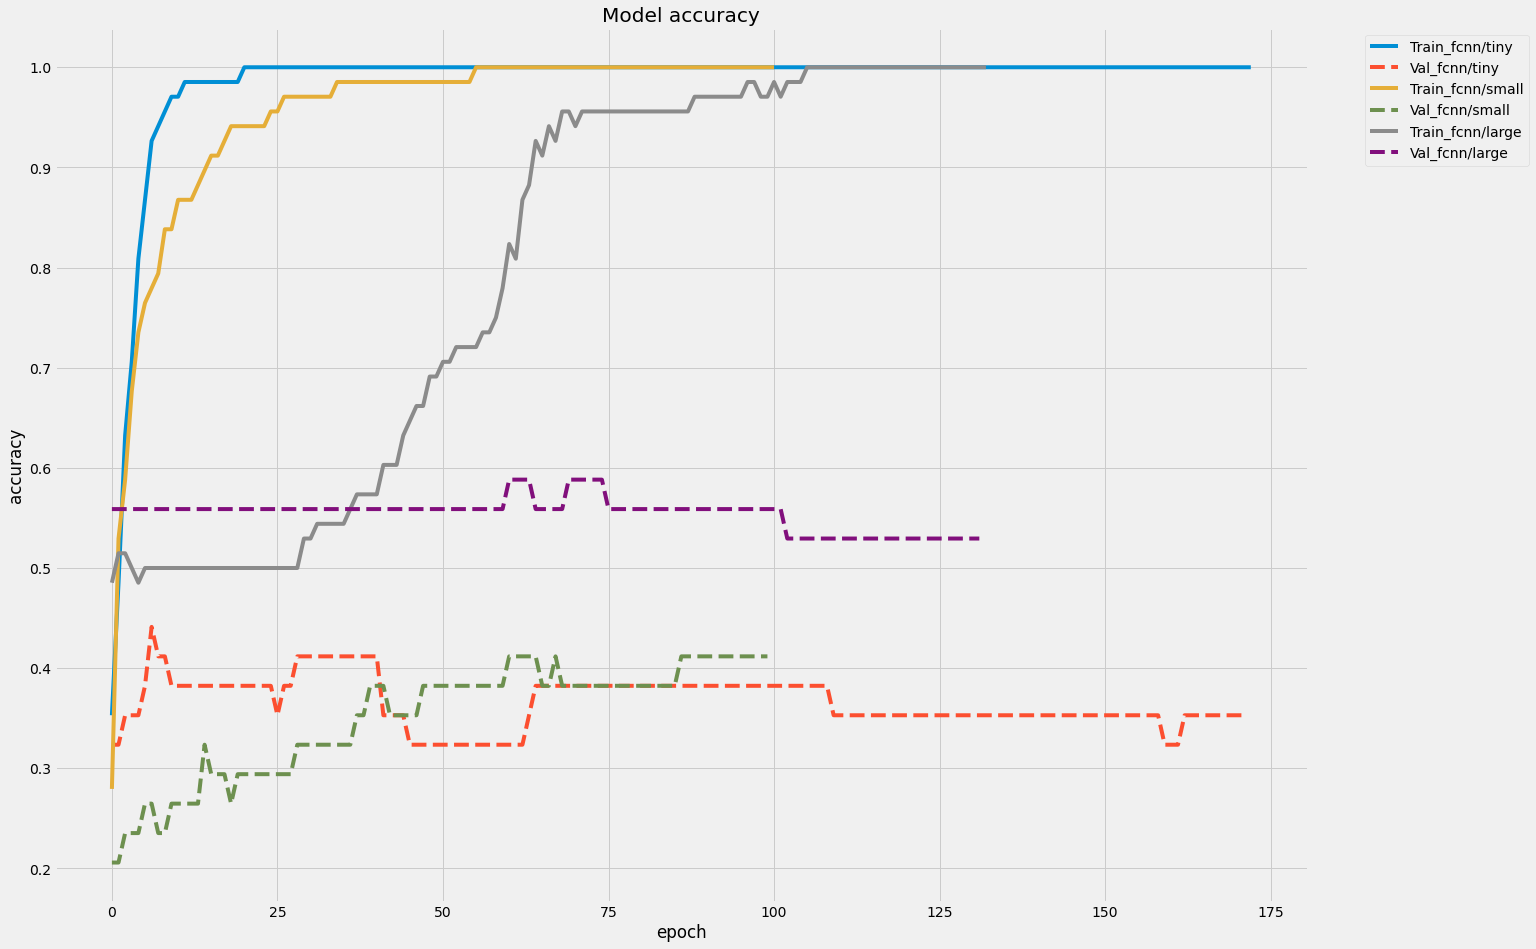

In [59]:
plot_report(size_histories)

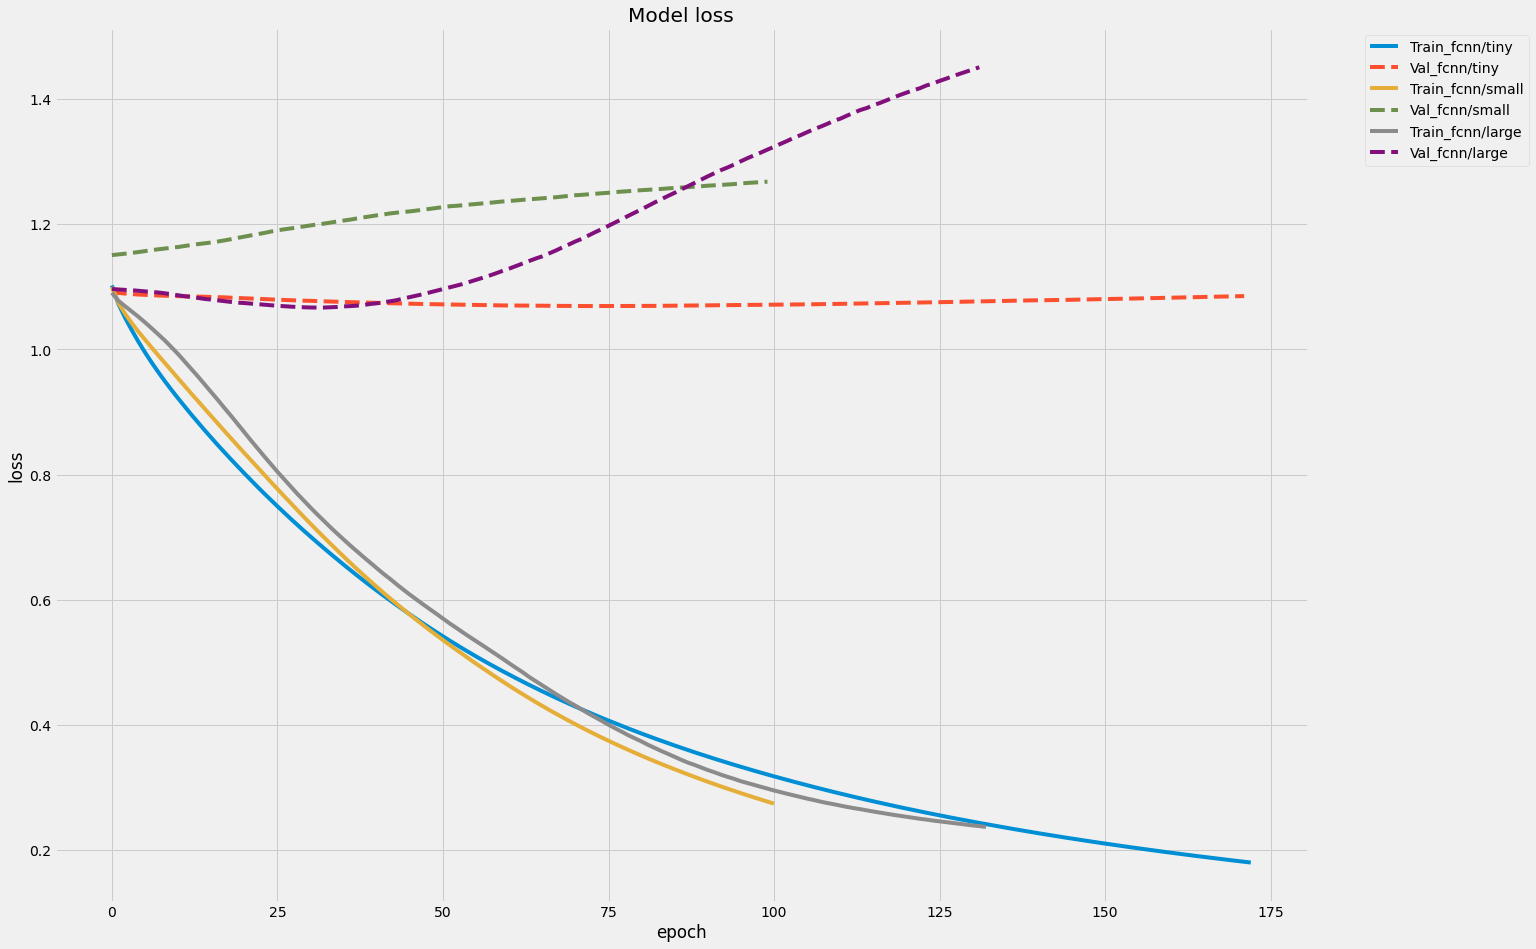

In [60]:
plot_report(size_histories, 'loss')

### Dropout

Although we got an accuracy of 0.75 looking at loss function chart is pretty obvious: There is overfiting. Now we have an overfitted NN let's make some adjustments to improve generalization capacity startin from dropout techniques.  

In [63]:
tiny_dropout = tf.keras.Sequential([
    tf.keras.layers.Dense(24, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)
])
size_histories['fcnn/tiny/dropout'] = compile_and_fit(tiny_dropout, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/tiny/dropout", 
                                                      optimizer=get_optimizer(), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATIO######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny/dropout'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny/dropout'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                106200    
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 16)                400       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 5

Epoch 49/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.6712 - accuracy: 0.5147 - val_loss: 1.0724 - val_accuracy: 0.5588
Epoch 50/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.6846 - accuracy: 0.5147 - val_loss: 1.0736 - val_accuracy: 0.5588
Epoch 51/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.6893 - accuracy: 0.5294 - val_loss: 1.0747 - val_accuracy: 0.5588
Epoch 52/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.6706 - accuracy: 0.5294 - val_loss: 1.0759 - val_accuracy: 0.5588
Epoch 53/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.6716 - accuracy: 0.5441 - val_loss: 1.0773 - val_accuracy: 0.5588
Epoch 54/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.6572 - accuracy: 0.5735 - val_loss: 1.0787 - val_accuracy: 0.5588
Epoch 55/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.6380 - accuracy: 0.5588 - val_loss: 1.0801 - val_accuracy: 0.5588

17/17 [==============================] - 0s 2ms/step - loss: 0.4331 - accuracy: 0.9265 - val_loss: 1.2086 - val_accuracy: 0.5882
Epoch 107/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.4355 - accuracy: 0.8382 - val_loss: 1.2126 - val_accuracy: 0.5882
Epoch 108/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.4452 - accuracy: 0.8676 - val_loss: 1.2167 - val_accuracy: 0.5882
Epoch 109/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.4179 - accuracy: 0.8971 - val_loss: 1.2210 - val_accuracy: 0.5588
Epoch 110/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.4190 - accuracy: 0.8382 - val_loss: 1.2245 - val_accuracy: 0.5588
Epoch 111/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.4366 - accuracy: 0.8529 - val_loss: 1.2284 - val_accuracy: 0.5588
Epoch 112/5000
17/17 [==============================] - 0s 2ms/step - loss: 0.4106 - accuracy: 0.8529 - val_loss: 1.2320 - val_accuracy: 0.5588
Epoch 1

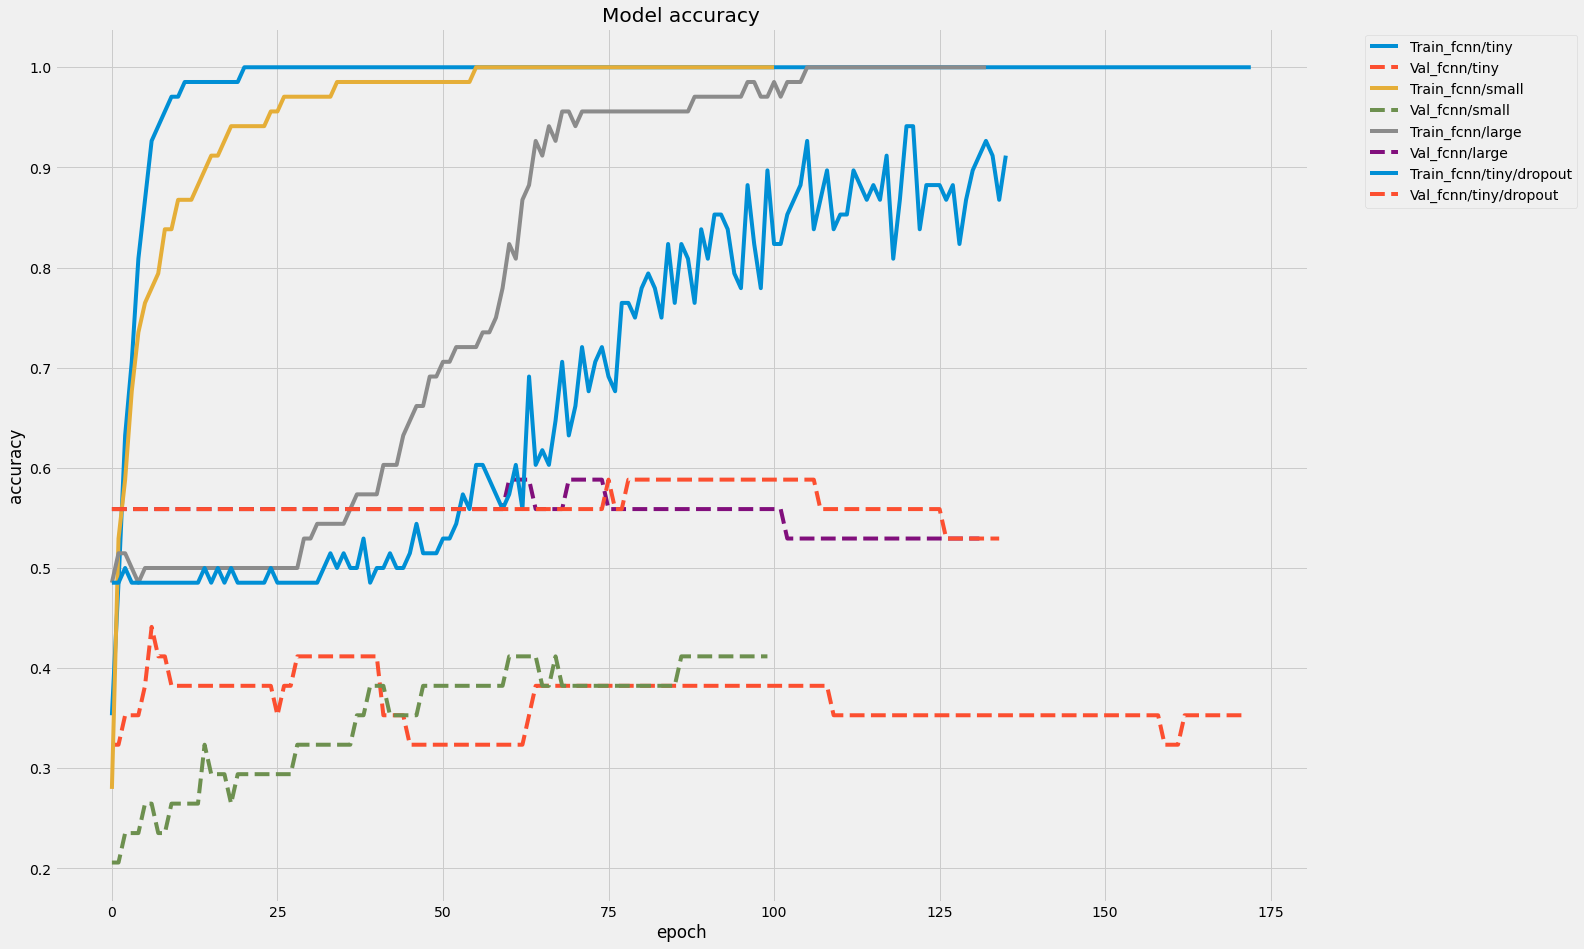

In [64]:
plot_report(size_histories)

Validation accuracy keeps improving more epoch with a total improvement from 0.75 to 0.81. Furthemore, the gap between training loss function and test loss function has been reduced.

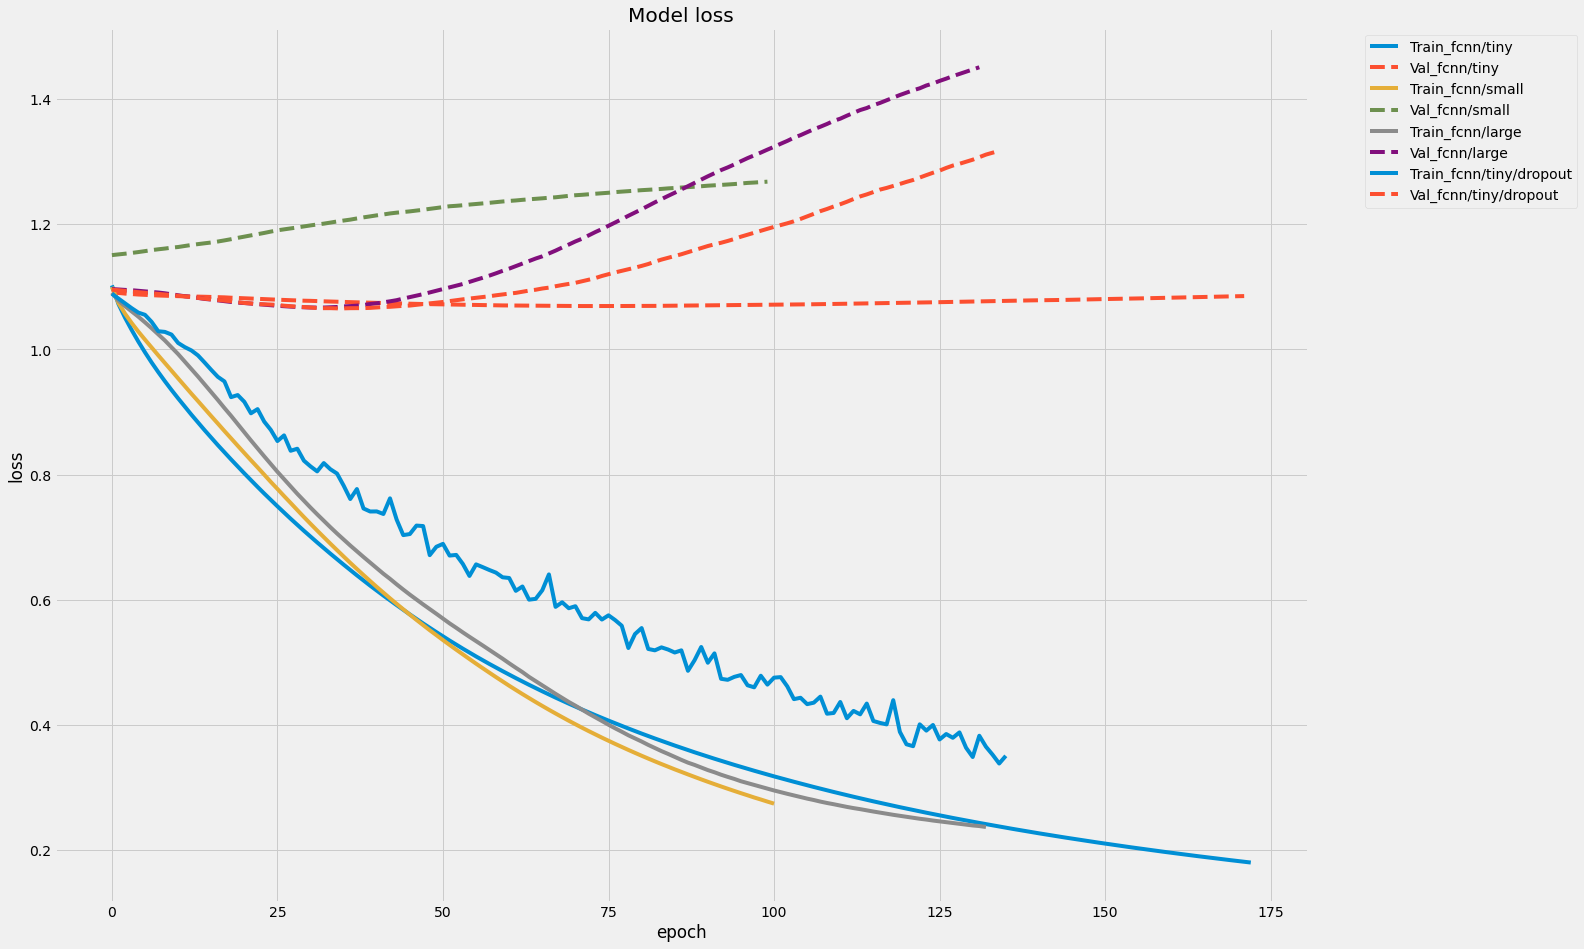

In [65]:
plot_report(size_histories, metric='loss')

### Kernel regularizer

In [66]:
# shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
# shutil.copytree(logdir/'fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['large'] = size_histories['fcnn/large']
regularizer_histories['dropout'] = size_histories['fcnn/tiny/dropout']

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [67]:
l2_model = tf.keras.Sequential([
    layers.Dense(24, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(24, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(16, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(16, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(num_classes, activation=tf.nn.softmax)
])
regularizer_histories['l2'] = compile_and_fit(l2_model, train_dataset, 
                                              test_dataset, 
                                              optimizer=tf.keras.optimizers.Adam(lr),
                                              name="regularizers/l2")
# Evaluate the model on the test data using `evaluate`
print("\n#######################EVALUATIO######################")
print('train acc:', max(regularizer_histories['l2'].history["accuracy"]))
print('test acc:', max(regularizer_histories['l2'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                106200    
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 16)                400       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 107,523
Trainable params: 107,523
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
17/17 [==============================

Epoch 51/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0401 - accuracy: 1.0000 - val_loss: 2.9575 - val_accuracy: 0.3824
Epoch 52/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 1.0000 - val_loss: 2.9913 - val_accuracy: 0.3824
Epoch 53/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0391 - accuracy: 1.0000 - val_loss: 3.0264 - val_accuracy: 0.3824
Epoch 54/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 1.0000 - val_loss: 3.0573 - val_accuracy: 0.3824
Epoch 55/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0381 - accuracy: 1.0000 - val_loss: 3.0919 - val_accuracy: 0.3824
Epoch 56/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0377 - accuracy: 1.0000 - val_loss: 3.1223 - val_accuracy: 0.3824
Epoch 57/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0373 - accuracy: 1.0000 - val_loss: 3.1446 - val_accuracy: 0.3824

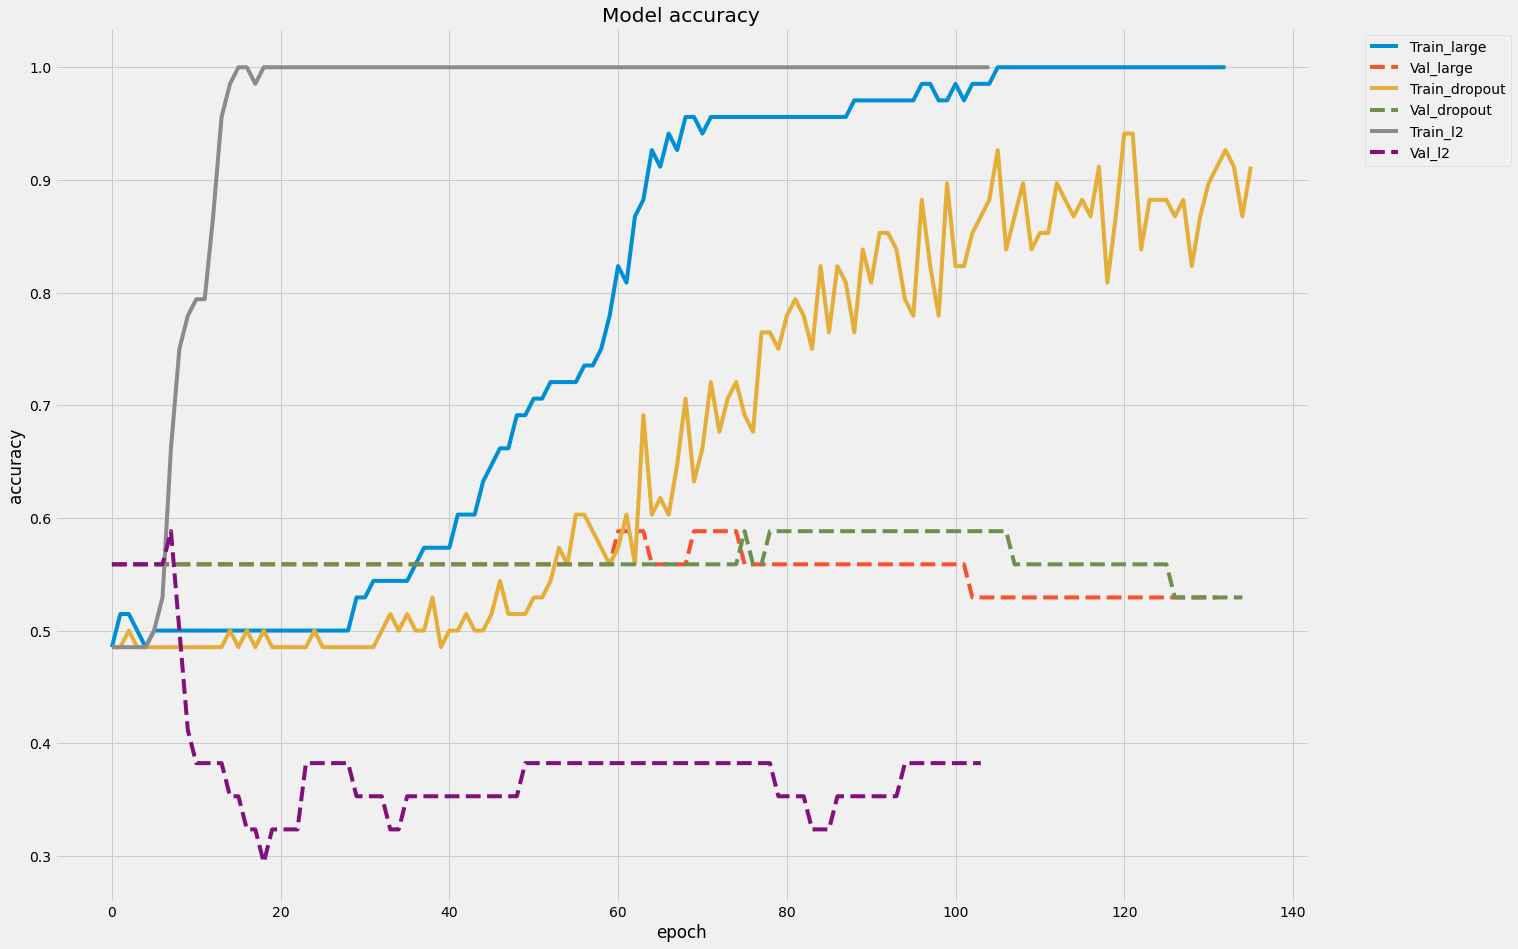

In [68]:
plot_report(regularizer_histories, 'accuracy')

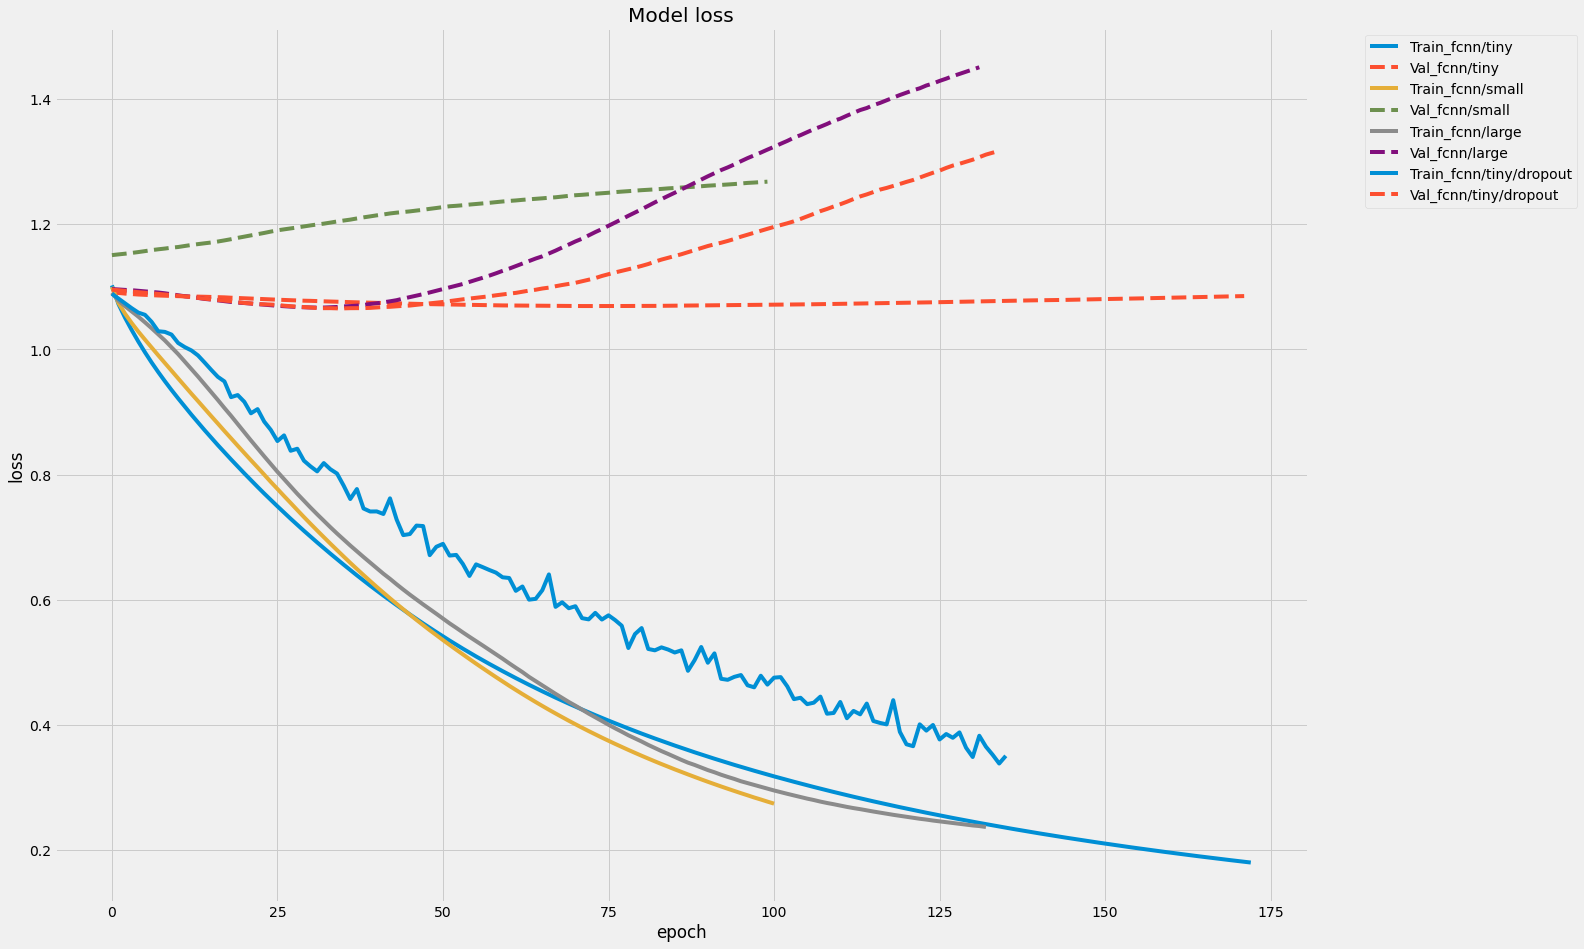

In [69]:
plot_report(size_histories, 'loss')

Now let's see what happens combining both techniques

In [73]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
combined_model = tf.keras.Sequential([
    layers.Dense(24, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(24, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(16, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(16, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    tf.keras.layers.Dropout(dr),
    layers.Dense(num_classes, activation=tf.nn.softmax)
])

tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
regularizer_histories['combined'] = compile_and_fit(combined_model, train_dataset, test_dataset, "regularizers/combined",
                                                   optimizer=get_optimizer())

# Evaluate the model on the test data using `evaluate`
print()
print('train acc:', max(regularizer_histories['combined'].history["accuracy"]))
print('test acc:', max(regularizer_histories['combined'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                106200    
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 16)                400       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 107,523
Trainable params: 107,523
Non-trai

Epoch 50/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.8120 - accuracy: 0.5000 - val_loss: 1.2276 - val_accuracy: 0.5588
Epoch 51/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.7930 - accuracy: 0.5147 - val_loss: 1.2284 - val_accuracy: 0.5588
Epoch 52/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.7798 - accuracy: 0.5147 - val_loss: 1.2291 - val_accuracy: 0.5588
Epoch 53/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.7699 - accuracy: 0.5735 - val_loss: 1.2297 - val_accuracy: 0.5588
Epoch 54/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.7699 - accuracy: 0.5882 - val_loss: 1.2304 - val_accuracy: 0.5588
Epoch 55/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.7581 - accuracy: 0.5588 - val_loss: 1.2316 - val_accuracy: 0.5588
Epoch 56/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.7685 - accuracy: 0.5735 - val_loss: 1.2324 - val_accuracy: 0.5588

17/17 [==============================] - 0s 2ms/step - loss: 0.5269 - accuracy: 0.9265 - val_loss: 1.3919 - val_accuracy: 0.5294
Epoch 108/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.5504 - accuracy: 0.9265 - val_loss: 1.3940 - val_accuracy: 0.5294
Epoch 109/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.5286 - accuracy: 0.9412 - val_loss: 1.3970 - val_accuracy: 0.5588
Epoch 110/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.5077 - accuracy: 0.9118 - val_loss: 1.4012 - val_accuracy: 0.5588
Epoch 111/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.5150 - accuracy: 0.8824 - val_loss: 1.4052 - val_accuracy: 0.5588
Epoch 112/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.5072 - accuracy: 0.9118 - val_loss: 1.4093 - val_accuracy: 0.5588
Epoch 113/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.5001 - accuracy: 0.9265 - val_loss: 1.4120 - val_accuracy: 0.5588
Epoch 1

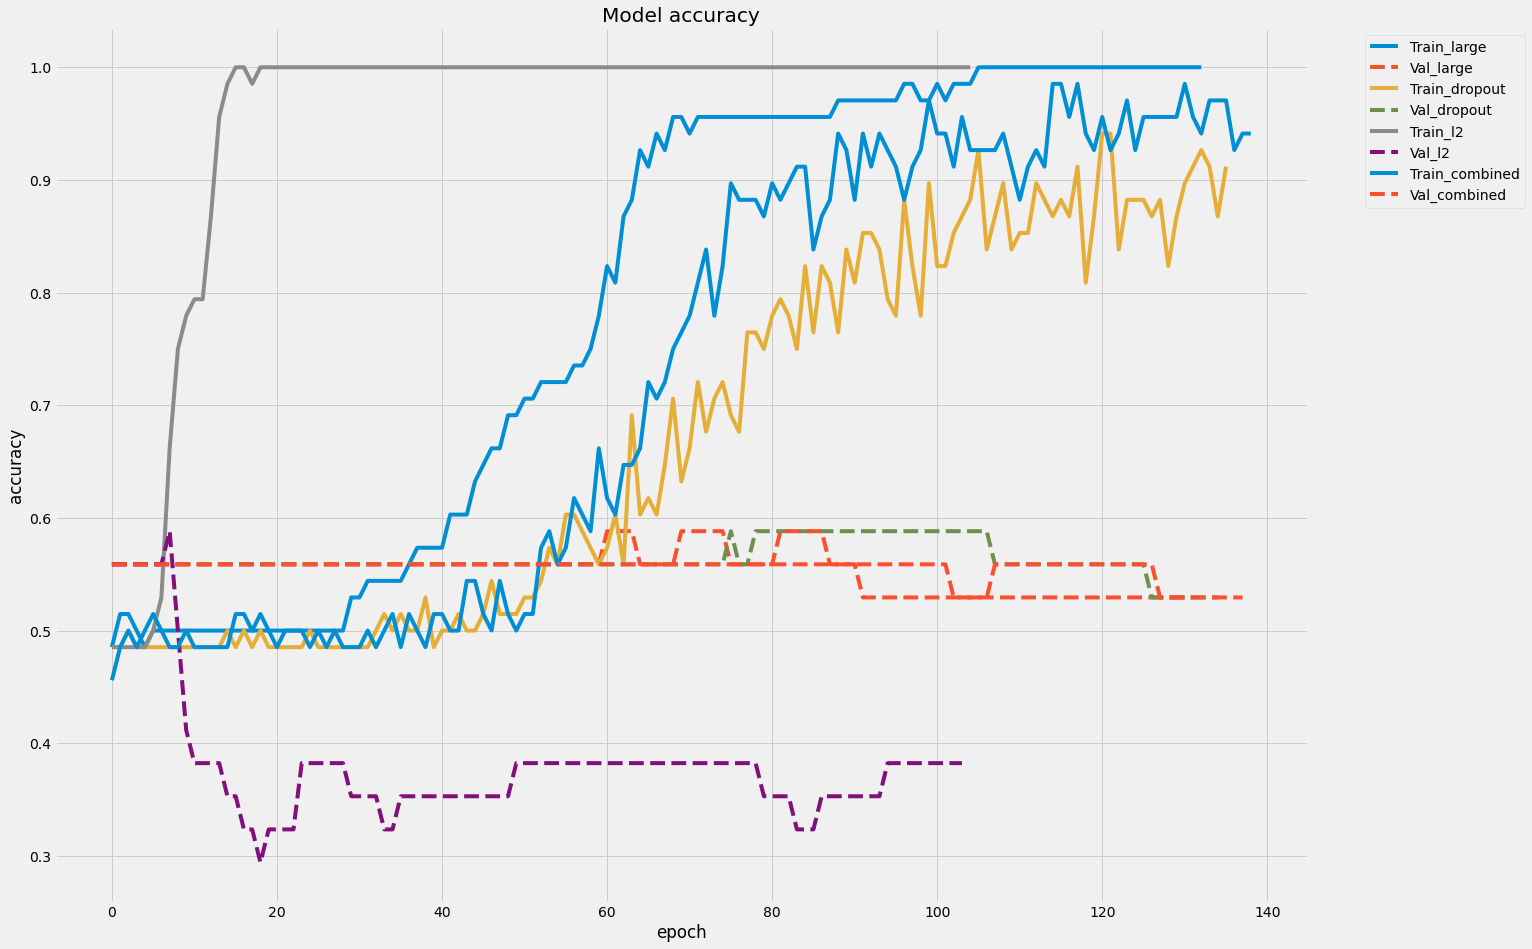

In [74]:
plot_report(regularizer_histories, 'accuracy')

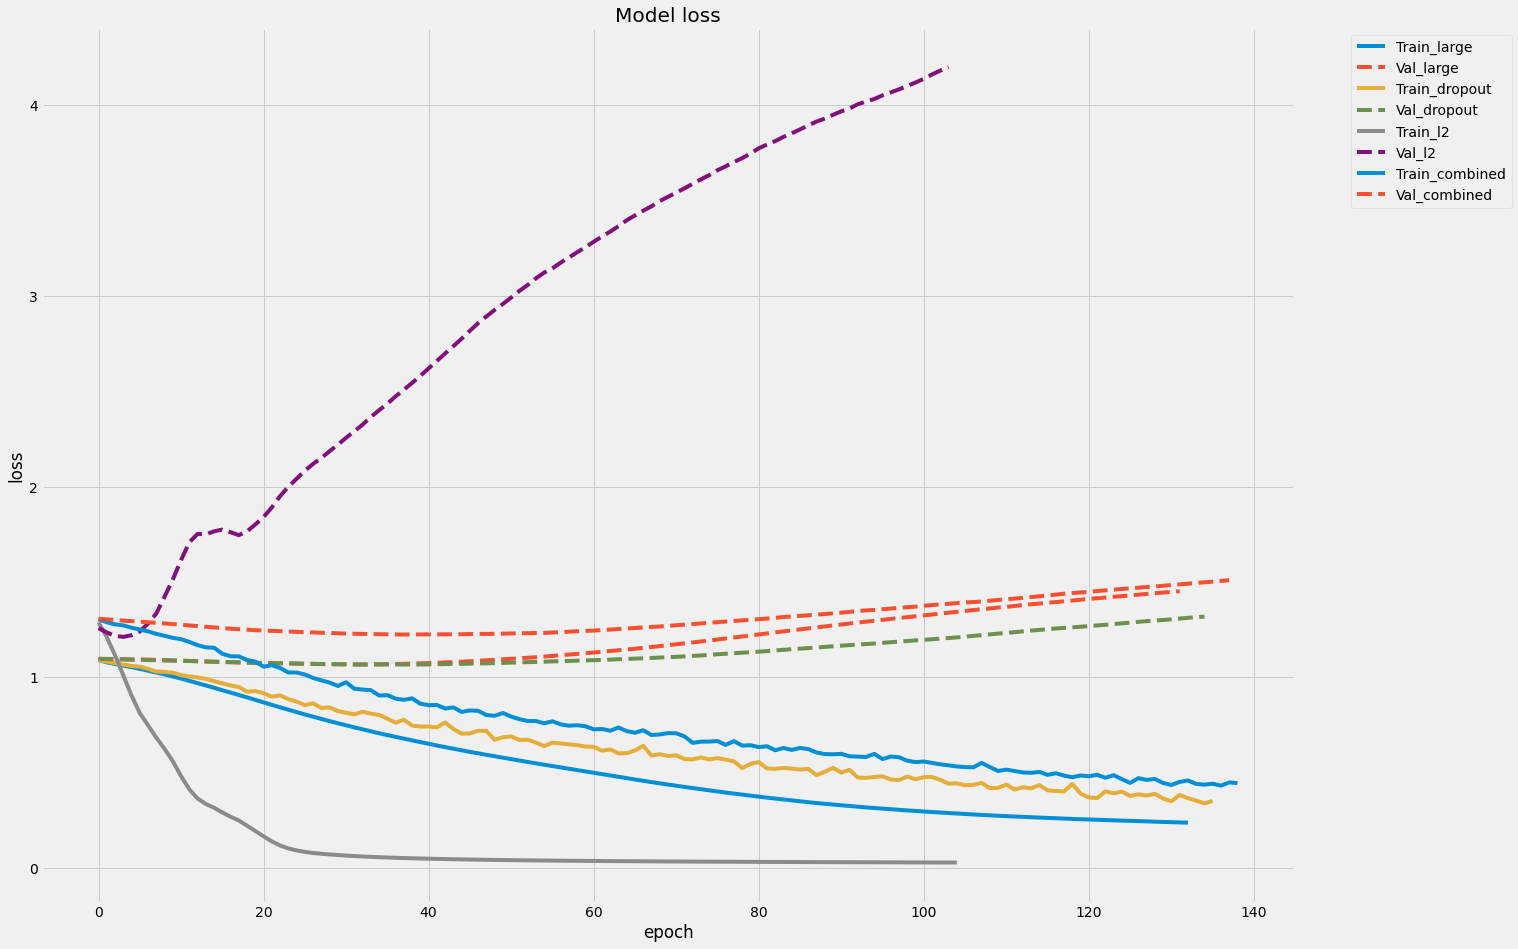

In [75]:
plot_report(regularizer_histories, 'loss')

## Batch Normalization

Batch normalization (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling. It was proposed by Sergey Ioffe and Christian Szegedy in 2015.

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Tensorflow implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)


In [77]:
batch_histories = {}
batch_histories['large'] = size_histories['fcnn/large']
batch_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [81]:
small_batch = tf.keras.Sequential([
    tf.keras.layers.Dense(24, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)
])
batch_histories['fcnn/small/batch'] = compile_and_fit(small_batch, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/small/batch", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(batch_histories['fcnn/small/batch'].history["accuracy"]))
print('test acc:', max(batch_histories['fcnn/small/batch'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                106200    
                                                                 
 batch_normalization (BatchN  (None, 24)               96        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 batch_normalization_1 (Batc  (None, 24)               96        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                400       
                                                                 
 batch_normalization_2 (Batc  (None, 16)               6

17/17 [==============================] - 0s 3ms/step - loss: 0.3287 - accuracy: 0.8824 - val_loss: 2.2922 - val_accuracy: 0.2941
Epoch 45/5000
17/17 [==============================] - 0s 3ms/step - loss: 0.3832 - accuracy: 0.8824 - val_loss: 2.3647 - val_accuracy: 0.2647
Epoch 46/5000
17/17 [==============================] - 0s 3ms/step - loss: 0.2448 - accuracy: 0.9559 - val_loss: 2.3900 - val_accuracy: 0.2647
Epoch 47/5000
17/17 [==============================] - 0s 3ms/step - loss: 0.3767 - accuracy: 0.8676 - val_loss: 2.3542 - val_accuracy: 0.2941
Epoch 48/5000
17/17 [==============================] - 0s 3ms/step - loss: 0.2961 - accuracy: 0.9118 - val_loss: 2.3297 - val_accuracy: 0.3235
Epoch 49/5000
17/17 [==============================] - 0s 3ms/step - loss: 0.3125 - accuracy: 0.8529 - val_loss: 2.3239 - val_accuracy: 0.3235
Epoch 50/5000
17/17 [==============================] - 0s 3ms/step - loss: 0.3370 - accuracy: 0.8529 - val_loss: 2.4161 - val_accuracy: 0.3235
Epoch 51/5000

17/17 [==============================] - 0s 3ms/step - loss: 0.1645 - accuracy: 0.9559 - val_loss: 3.0333 - val_accuracy: 0.1765

#######################EVALUATION######################
train acc: 0.9852941036224365
test acc: 0.3235294222831726


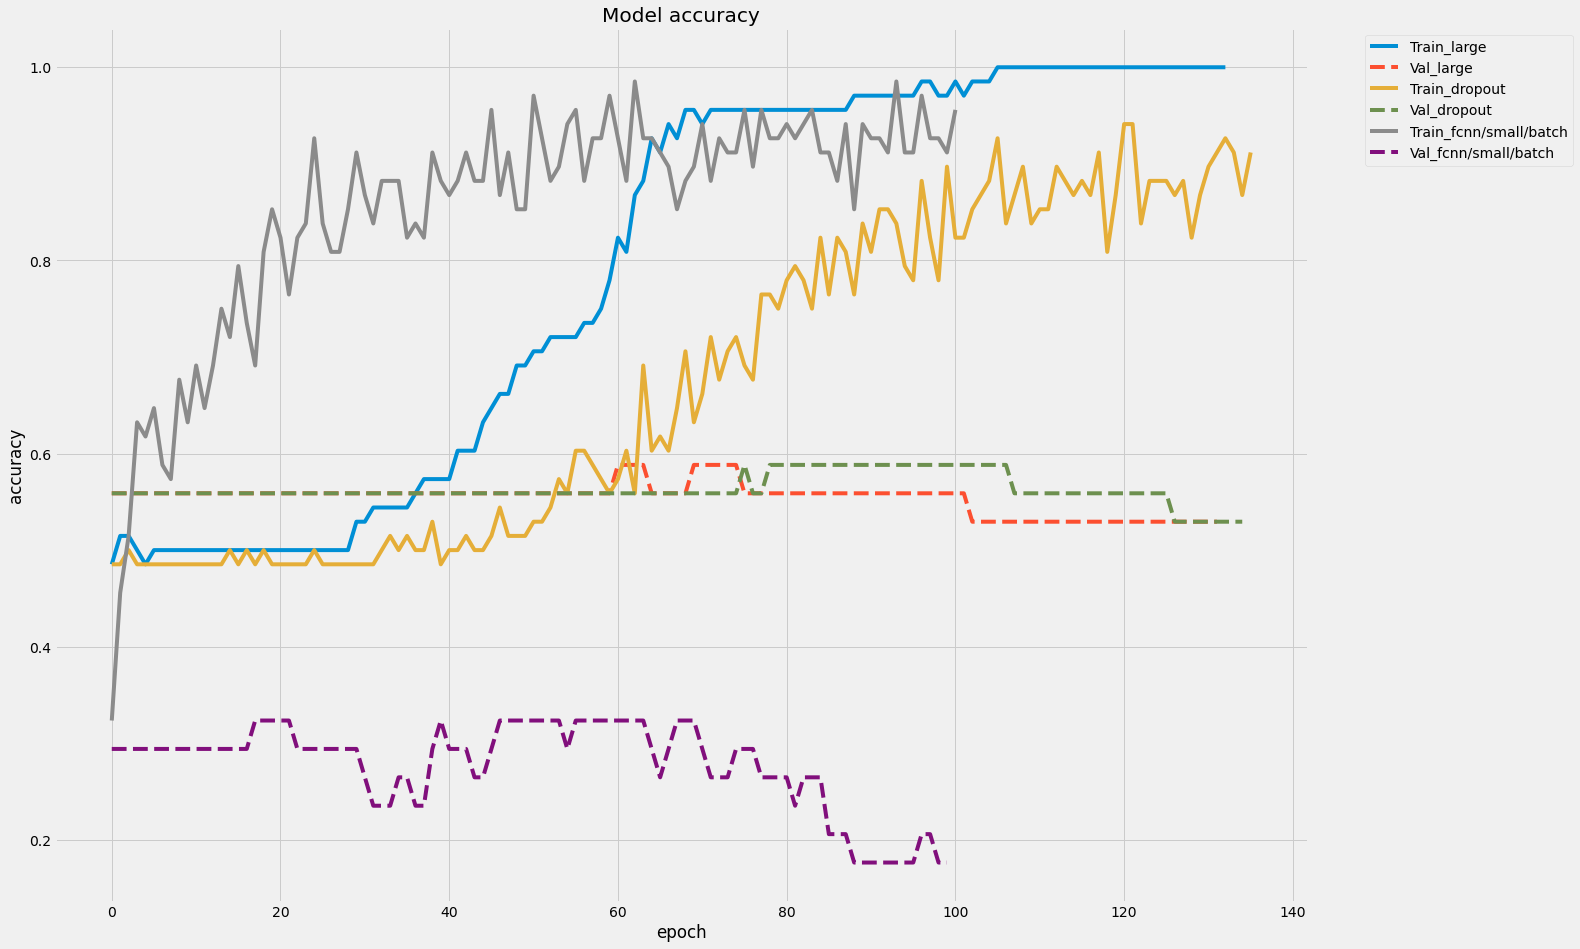

In [82]:
plot_report(batch_histories, 'accuracy')

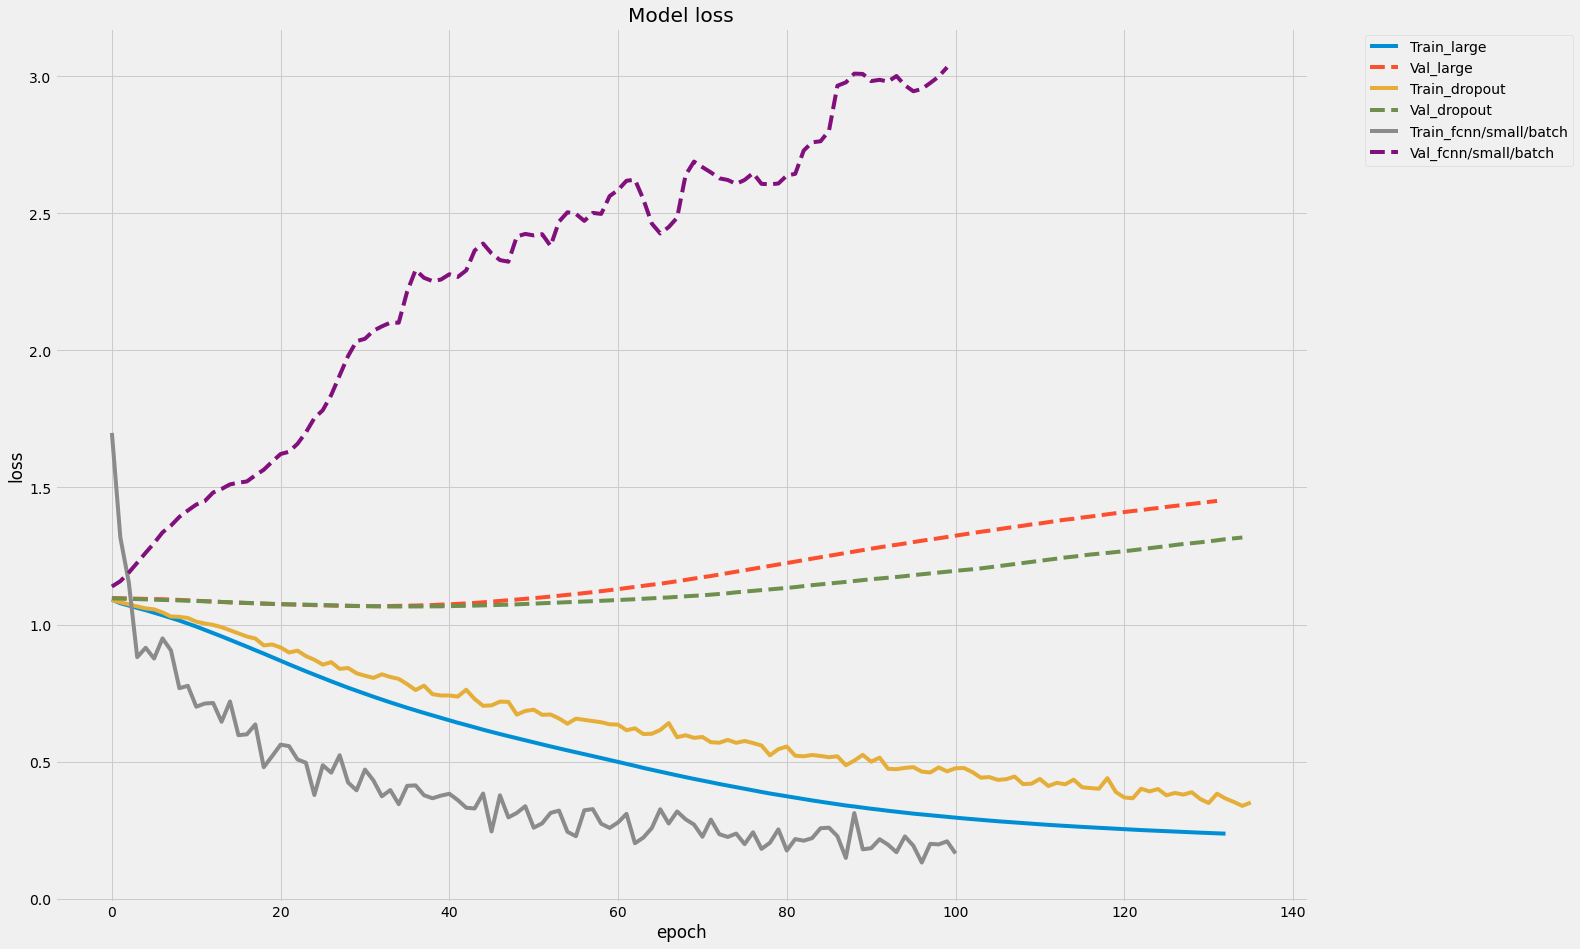

In [83]:
plot_report(batch_histories, 'loss')

## LSTM-FCNN

Univariate time series classification model, the Long Short Term Memory Fully Convolutional Network (LSTM-FCN) to capture time related information

In [84]:
X = features
X.shape

(102, 158, 28)

In [86]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

In [87]:
lstm_histories = {}
#lstm_histories['large'] = size_histories['fcnn/large']
#lstm_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [89]:
lstm_units=512
lstm_tiny_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2),
                         input_shape=[X.shape[1],X.shape[2],]
                        ),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
#     tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/tiny'] = compile_and_fit(lstm_tiny_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                              
                                               name="lstm/tiny", 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/tiny'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/tiny'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 512)               1107968   
                                                                 
 dense (Dense)               (None, 100)               51300     
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 1,159,571
Trainable params: 1,159,571
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
17/17 [==============================] - 2s 29ms/step - loss: 1.1178 - accuracy: 0.4559 - val_loss: 1.0905 - val_accuracy: 0.5588
Epoch 2/1000
17/17 [==============================] - 0s 12ms/step - loss: 1.0842 - accuracy: 0.5147 - val_loss: 1.0826 - val_accuracy: 0.5588
Epoch 3/1000
17/17 [====

17/17 [==============================] - 0s 12ms/step - loss: 0.3126 - accuracy: 0.8676 - val_loss: 2.8778 - val_accuracy: 0.3824
Epoch 53/1000
17/17 [==============================] - 0s 12ms/step - loss: 0.3117 - accuracy: 0.8971 - val_loss: 2.5963 - val_accuracy: 0.3529
Epoch 54/1000
17/17 [==============================] - 0s 12ms/step - loss: 0.2763 - accuracy: 0.9118 - val_loss: 2.8227 - val_accuracy: 0.3824
Epoch 55/1000
17/17 [==============================] - 0s 12ms/step - loss: 0.2709 - accuracy: 0.9118 - val_loss: 2.6982 - val_accuracy: 0.3529
Epoch 56/1000
17/17 [==============================] - 0s 12ms/step - loss: 0.1894 - accuracy: 0.9559 - val_loss: 2.8495 - val_accuracy: 0.4118
Epoch 57/1000
17/17 [==============================] - 0s 12ms/step - loss: 0.1510 - accuracy: 0.9559 - val_loss: 3.2454 - val_accuracy: 0.3529
Epoch 58/1000
17/17 [==============================] - 0s 12ms/step - loss: 0.1358 - accuracy: 0.9559 - val_loss: 3.2833 - val_accuracy: 0.3529
Epoch 

Epoch 109/1000
17/17 [==============================] - 0s 12ms/step - loss: 1.0810 - accuracy: 0.4853 - val_loss: 1.1419 - val_accuracy: 0.5588
Epoch 110/1000
17/17 [==============================] - 0s 12ms/step - loss: 1.0829 - accuracy: 0.4853 - val_loss: 1.1414 - val_accuracy: 0.5588
Epoch 111/1000
17/17 [==============================] - 0s 12ms/step - loss: 1.0848 - accuracy: 0.4853 - val_loss: 1.1364 - val_accuracy: 0.5588
Epoch 112/1000
17/17 [==============================] - 0s 12ms/step - loss: 1.0848 - accuracy: 0.4853 - val_loss: 1.1388 - val_accuracy: 0.5588
Epoch 113/1000
17/17 [==============================] - 0s 12ms/step - loss: 1.0851 - accuracy: 0.4853 - val_loss: 1.1413 - val_accuracy: 0.5588
Epoch 114/1000
17/17 [==============================] - 0s 12ms/step - loss: 1.0846 - accuracy: 0.4853 - val_loss: 1.1413 - val_accuracy: 0.5588
Epoch 115/1000
17/17 [==============================] - 0s 12ms/step - loss: 1.0841 - accuracy: 0.4853 - val_loss: 1.1409 - val_ac

17/17 [==============================] - 0s 13ms/step - loss: 1.0769 - accuracy: 0.4853 - val_loss: 1.1388 - val_accuracy: 0.5588
Epoch 166/1000
17/17 [==============================] - 0s 12ms/step - loss: 1.0767 - accuracy: 0.4853 - val_loss: 1.1387 - val_accuracy: 0.5588
Epoch 167/1000
17/17 [==============================] - 0s 12ms/step - loss: 1.0766 - accuracy: 0.4853 - val_loss: 1.1386 - val_accuracy: 0.5588

#######################EVALUATION######################
train acc: 0.970588207244873
test acc: 0.5588235259056091


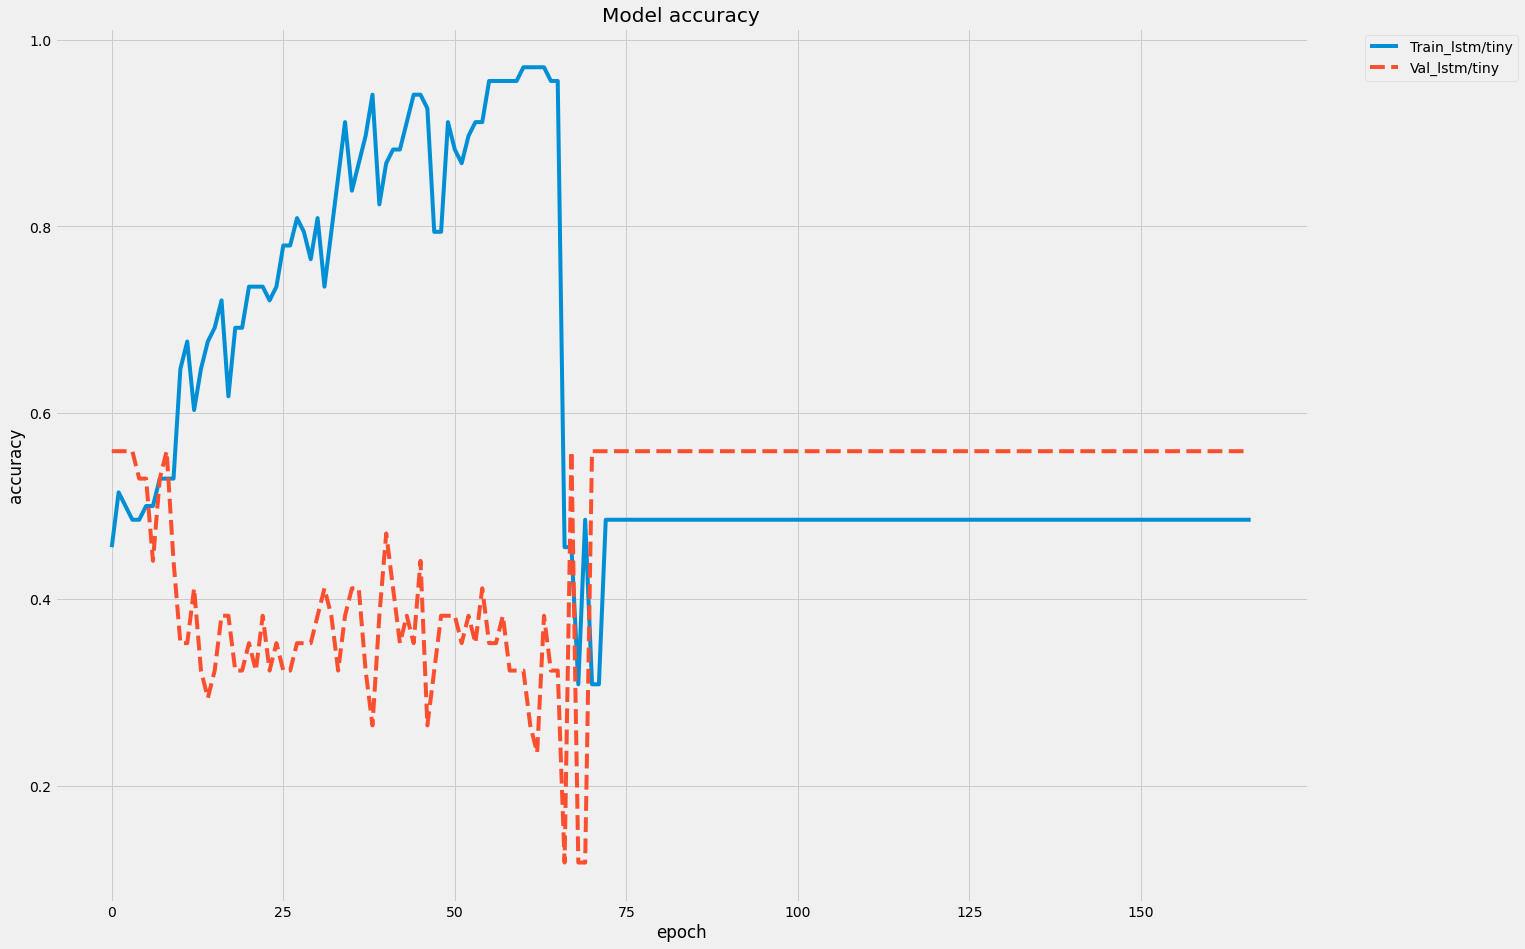

In [90]:
plot_report(lstm_histories, 'accuracy')

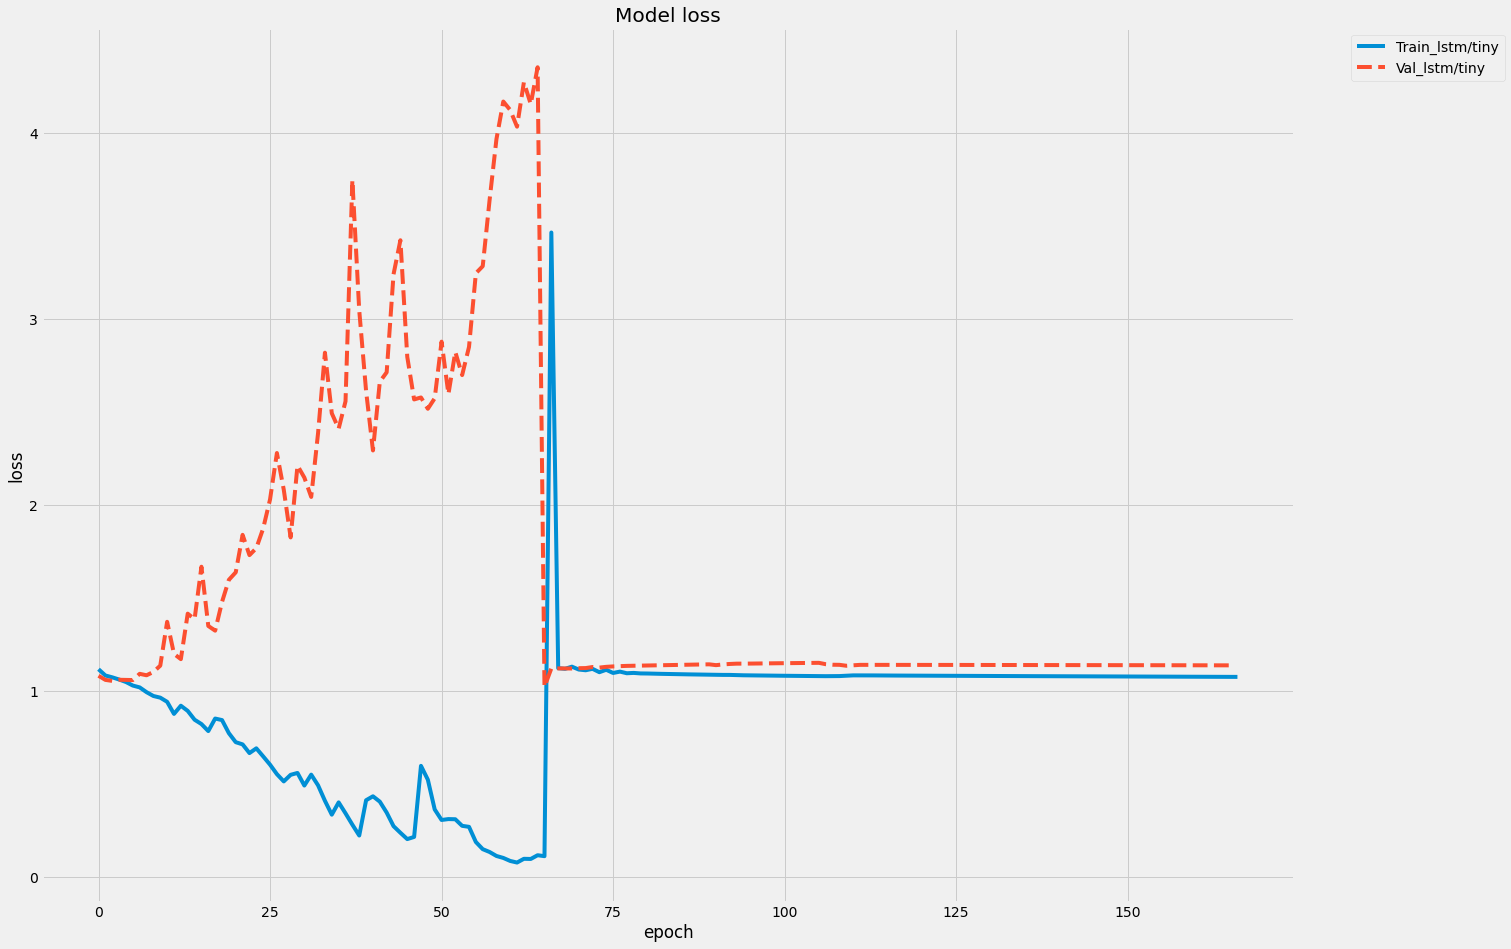

In [91]:
plot_report(lstm_histories, 'loss')

In [93]:
lstm_small_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2),
                         input_shape=[X.shape[1],X.shape[2],]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/small'] = compile_and_fit(lstm_small_model, 
                                               train_dataset, 
                                               test_dataset, 
#                                               optimizer=tf.keras.optimizers.Adam(lr), 
                                                optimizer=get_optimizer(lr=1e-4,
                                                                        multiplier=10),
                                               name="lstm/small", 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/small'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/small'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 158, 512)          1107968   
                                                                 
 batch_normalization (BatchN  (None, 158, 512)         2048      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 8)                 4104      
                                                                 
 dropout (Dropout)           (None, 8)                 0

17/17 [==============================] - 0s 25ms/step - loss: 0.5880 - accuracy: 0.7353 - val_loss: 1.7750 - val_accuracy: 0.4118
Epoch 48/5000
17/17 [==============================] - 0s 25ms/step - loss: 0.6098 - accuracy: 0.7647 - val_loss: 1.7940 - val_accuracy: 0.4118
Epoch 49/5000
17/17 [==============================] - 0s 25ms/step - loss: 0.5956 - accuracy: 0.7941 - val_loss: 1.8222 - val_accuracy: 0.4118
Epoch 50/5000
17/17 [==============================] - 0s 25ms/step - loss: 0.6186 - accuracy: 0.7647 - val_loss: 1.8525 - val_accuracy: 0.3824
Epoch 51/5000
17/17 [==============================] - 0s 25ms/step - loss: 0.6296 - accuracy: 0.7794 - val_loss: 1.8758 - val_accuracy: 0.3824
Epoch 52/5000
17/17 [==============================] - 0s 24ms/step - loss: 0.6595 - accuracy: 0.7206 - val_loss: 1.8875 - val_accuracy: 0.3824
Epoch 53/5000
17/17 [==============================] - 0s 24ms/step - loss: 0.6299 - accuracy: 0.7794 - val_loss: 1.8948 - val_accuracy: 0.3824
Epoch 

Epoch 104/5000
17/17 [==============================] - 0s 25ms/step - loss: 0.6159 - accuracy: 0.6912 - val_loss: 2.0128 - val_accuracy: 0.3824
Epoch 105/5000
17/17 [==============================] - 0s 24ms/step - loss: 0.6148 - accuracy: 0.7206 - val_loss: 2.0132 - val_accuracy: 0.3824
Epoch 106/5000
17/17 [==============================] - 0s 25ms/step - loss: 0.6245 - accuracy: 0.7206 - val_loss: 2.0099 - val_accuracy: 0.3824
Epoch 107/5000
17/17 [==============================] - 0s 25ms/step - loss: 0.5831 - accuracy: 0.7794 - val_loss: 2.0102 - val_accuracy: 0.3824
Epoch 108/5000
17/17 [==============================] - 0s 25ms/step - loss: 0.5507 - accuracy: 0.7353 - val_loss: 2.0150 - val_accuracy: 0.3824
Epoch 109/5000
17/17 [==============================] - 0s 25ms/step - loss: 0.6065 - accuracy: 0.7500 - val_loss: 2.0139 - val_accuracy: 0.3824
Epoch 110/5000
17/17 [==============================] - 0s 25ms/step - loss: 0.5602 - accuracy: 0.7353 - val_loss: 2.0158 - val_ac

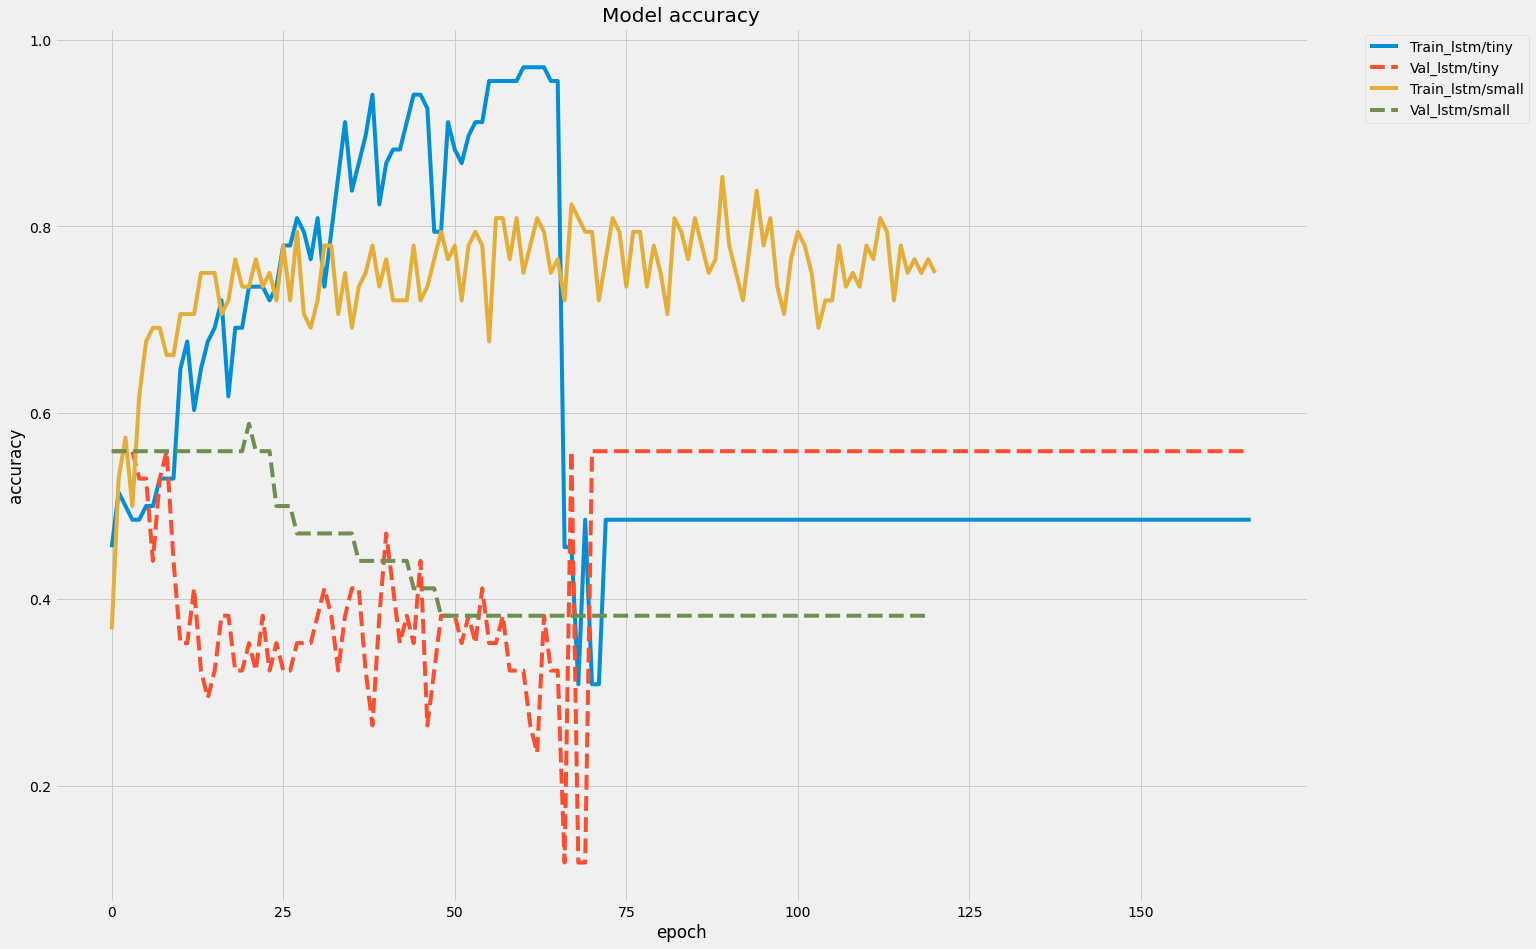

In [94]:
plot_report(lstm_histories, 'accuracy')

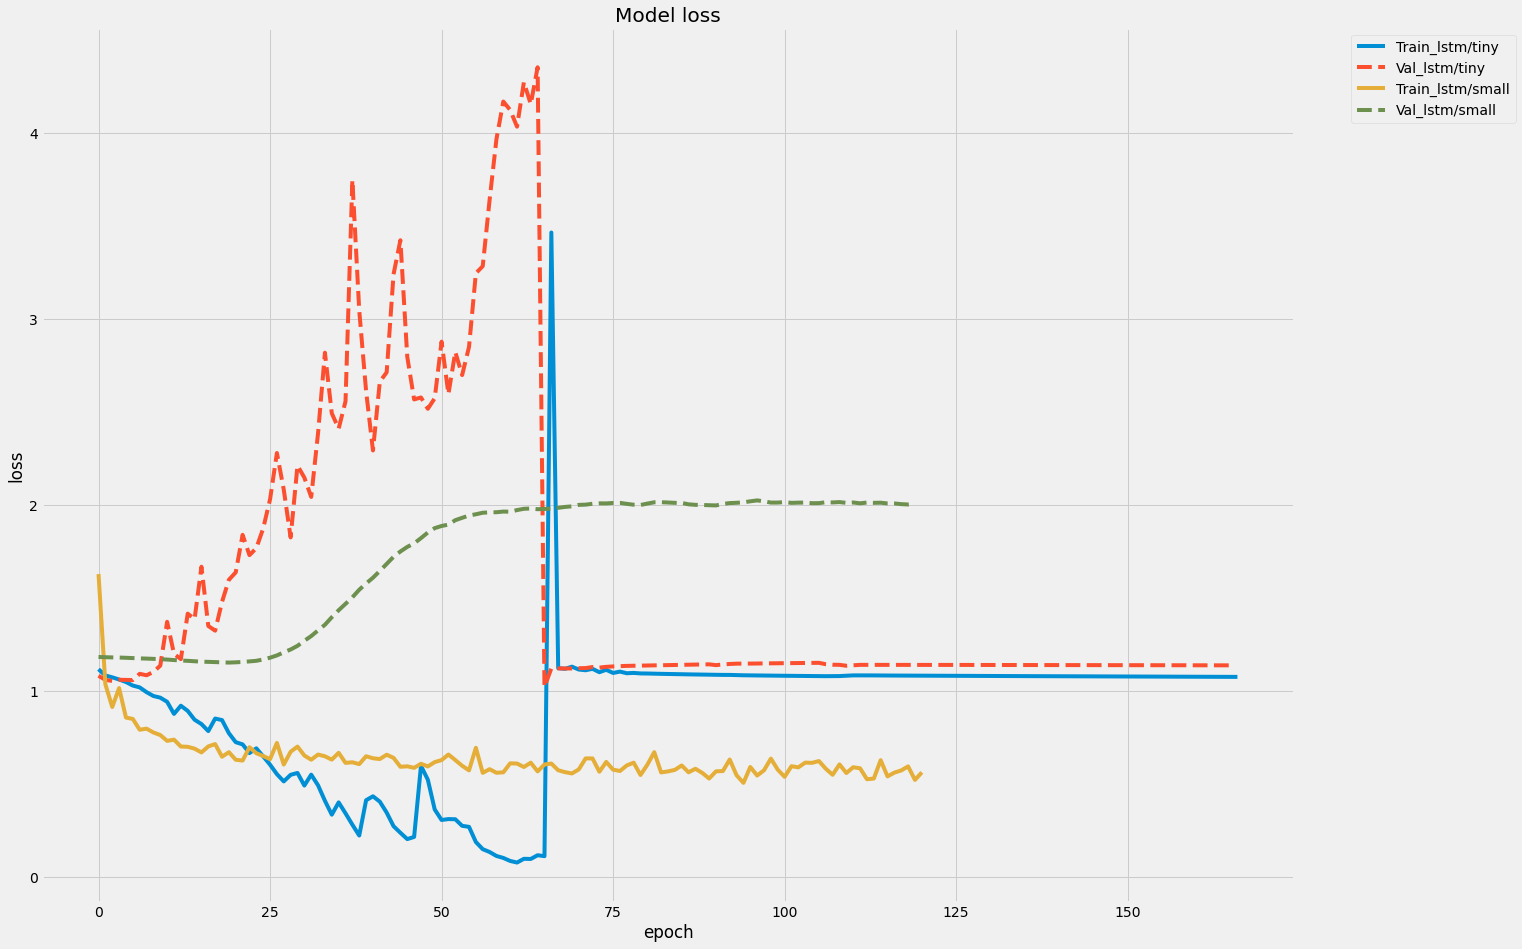

In [95]:
plot_report(lstm_histories, 'loss')

In [98]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_large_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2),
                         input_shape=[X.shape[1],X.shape[2],]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(24, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/large'] = compile_and_fit(lstm_large_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                lr=1e-4,
#                                                multiplier=10), 
                                                name="lstm/large")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/large'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 158, 512)          1107968   
                                                                 
 batch_normalization (BatchN  (None, 158, 512)         2048      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 24)                12312     
                                                                 
 batch_normalization_2 (Batc  (None, 24)               9

17/17 [==============================] - 0s 26ms/step - loss: 1.1949 - accuracy: 0.4118 - val_loss: 11.0089 - val_accuracy: 0.3235
Epoch 40/1000
17/17 [==============================] - 0s 26ms/step - loss: 1.1509 - accuracy: 0.4118 - val_loss: 12.1323 - val_accuracy: 0.3235
Epoch 41/1000
17/17 [==============================] - 0s 26ms/step - loss: 1.0933 - accuracy: 0.5294 - val_loss: 8.7804 - val_accuracy: 0.3235
Epoch 42/1000
17/17 [==============================] - 0s 26ms/step - loss: 1.0399 - accuracy: 0.5441 - val_loss: 7.0682 - val_accuracy: 0.3235
Epoch 43/1000
17/17 [==============================] - 0s 26ms/step - loss: 0.9742 - accuracy: 0.7059 - val_loss: 9.5656 - val_accuracy: 0.3235
Epoch 44/1000
17/17 [==============================] - 0s 26ms/step - loss: 1.0299 - accuracy: 0.5588 - val_loss: 12.5079 - val_accuracy: 0.3235
Epoch 45/1000
17/17 [==============================] - 0s 26ms/step - loss: 0.9424 - accuracy: 0.6765 - val_loss: 14.4138 - val_accuracy: 0.3235
Ep

Epoch 96/1000
17/17 [==============================] - 0s 25ms/step - loss: 0.5942 - accuracy: 0.8529 - val_loss: 220.5428 - val_accuracy: 0.3235
Epoch 97/1000
17/17 [==============================] - 0s 24ms/step - loss: 0.8206 - accuracy: 0.7353 - val_loss: 238.2294 - val_accuracy: 0.3235
Epoch 98/1000
17/17 [==============================] - 0s 24ms/step - loss: 1.1057 - accuracy: 0.6324 - val_loss: 12.1607 - val_accuracy: 0.1471
Epoch 99/1000
17/17 [==============================] - 0s 25ms/step - loss: 1.5683 - accuracy: 0.4559 - val_loss: 2.4527 - val_accuracy: 0.2647
Epoch 100/1000
17/17 [==============================] - 0s 24ms/step - loss: 1.0436 - accuracy: 0.6029 - val_loss: 5.9383 - val_accuracy: 0.3235
Epoch 101/1000
17/17 [==============================] - 0s 25ms/step - loss: 1.2093 - accuracy: 0.4853 - val_loss: 14.3689 - val_accuracy: 0.3235
Epoch 102/1000
17/17 [==============================] - 0s 25ms/step - loss: 1.0017 - accuracy: 0.6324 - val_loss: 21.3096 - val

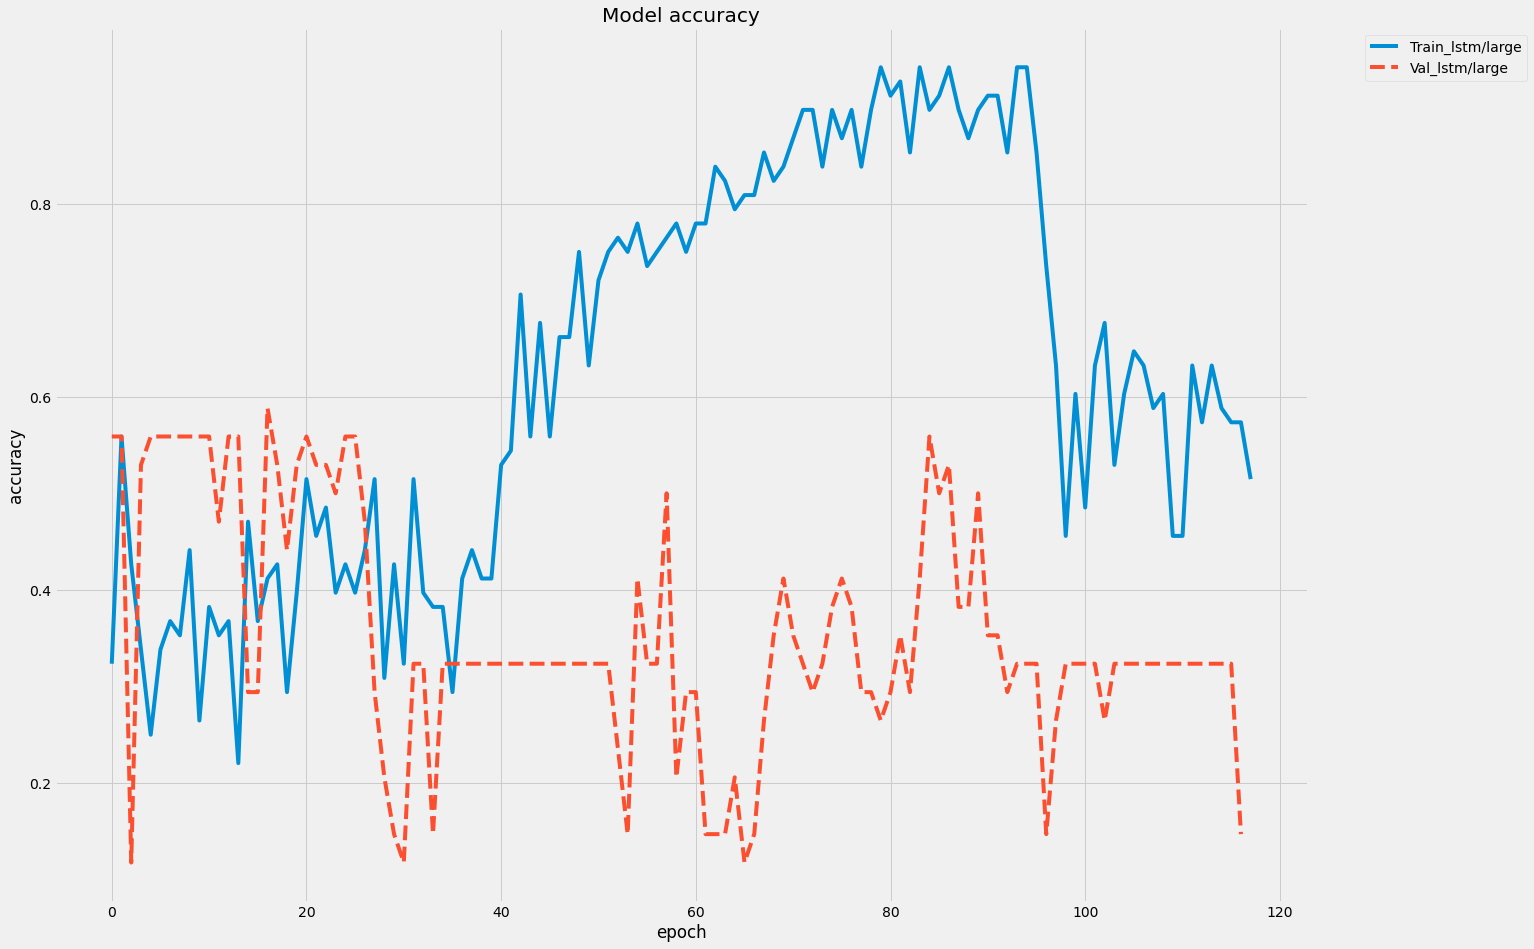

In [99]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'accuracy')

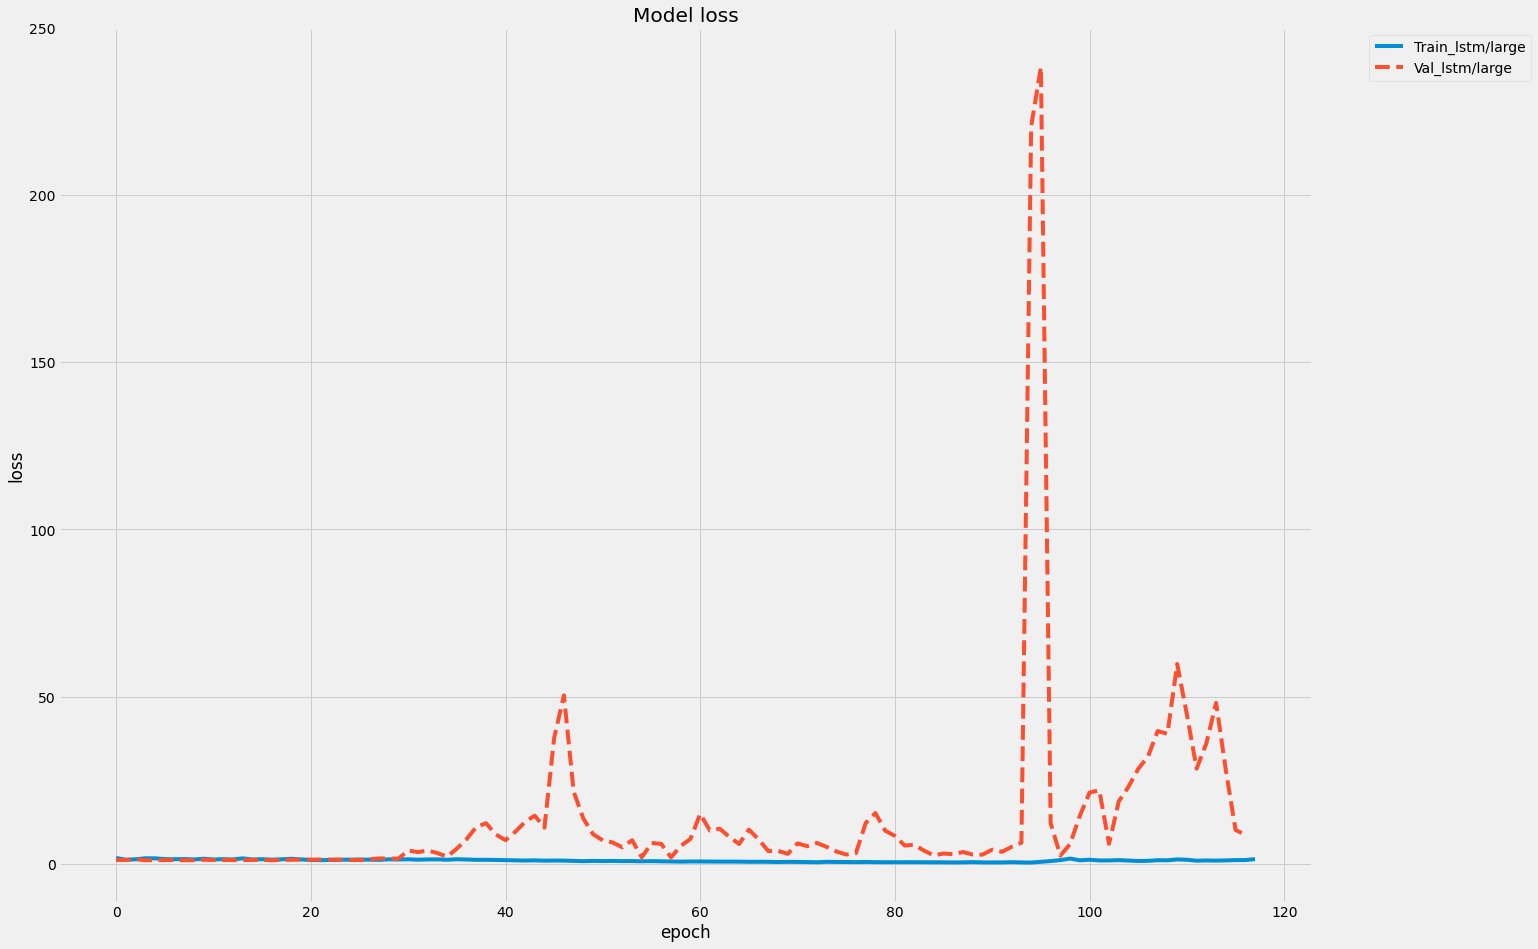

In [100]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'loss')